##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 이미지 분류

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 튜토리얼은 `tf.keras.Sequential` 모델을 사용하여 꽃 이미지를 분류하고 `tf.keras.utils.image_dataset_from_directory`를 사용하여 데이터를 로드하는 방법을 보여줍니다. 다음 개념을 설명합니다.

- 디스크에서 데이터세트를 효율적으로 로드합니다.
- 데이터 증강 및 드롭아웃을 포함하여 과대적합을 식별하고 이를 완화하는 기술을 적용합니다.

이 튜토리얼은 기본적인 머신러닝 워크플로를 따릅니다.

1. 데이터 검사 및 이해하기
2. 입력 파이프라인 빌드하기
3. 모델 빌드하기
4. 모델 훈련하기
5. 모델 테스트하기
6. 모델을 개선하고 프로세스 반복하기

또한 이 노트북은 모바일, 임베디드 및 IoT 장치에서 온디바이스 머신 러닝을 위해 [저장된 모델](../../../guide/saved_model.ipynb)을 [TensorFlow Lite](https://www.tensorflow.org/lite/) 모델로 변환하는 방법을 보여줍니다.

## 설정

TensorFlow 및 기타 필요한 라이브러리를 가져옵니다.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 데이터세트 다운로드 및 탐색하기

이 튜토리얼에서는 약 3,700장의 꽃 사진 데이터세트를 사용합니다. 데이터세트에는 클래스당 하나씩 5개의 하위 디렉터리가 있습니다.

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# 파일을 저장할 최상위 디렉토리 (D 드라이브의 루트)
base_cache_dir = "d:/"

# cache_dir 아래에 생성될 최종 폴더 이름
# get_file은 보통 이 이름 아래에 파일을 풀어놓습니다.
target_subdir = "flower_photos_data" 

data_dir_path = tf.keras.utils.get_file(
    # fname: 다운로드될 파일 이름 (tgz 파일의 이름).
    fname='flower_photos.tgz',
    origin=dataset_url,
    untar=True,
    # [수정] cache_dir을 D 드라이브 루트로 지정
    cache_dir=base_cache_dir,
    # [수정] cache_subdir을 target_subdir로 지정
    cache_subdir=target_subdir
)

data_dir = pathlib.Path(data_dir_path)

print(f"다운로드 및 압축 해제된 최종 경로: {data_dir}")


228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step
다운로드 및 압축 해제된 최종 경로: d:\flower_photos_data\flower_photos_extracted


다운로드 후, 데이터세트 사본을 사용할 수 있습니다. 총 3,670개의 이미지가 있습니다.

In [17]:
data_dir = "D:/flower_photos_data/flower_photos_extracted/flower_photos"
data_dir = pathlib.Path(data_dir)

print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

D:\flower_photos_data\flower_photos_extracted\flower_photos
3670


장미의 경우는 다음과 같습니다.

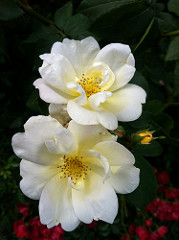

In [18]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

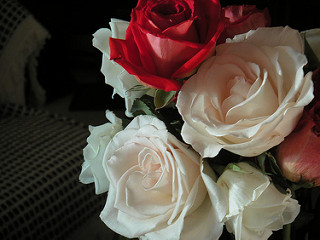

In [19]:
PIL.Image.open(str(roses[1]))

그리고 일부 튤립이 있습니다.

In [1]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

NameError: name 'data_dir' is not defined

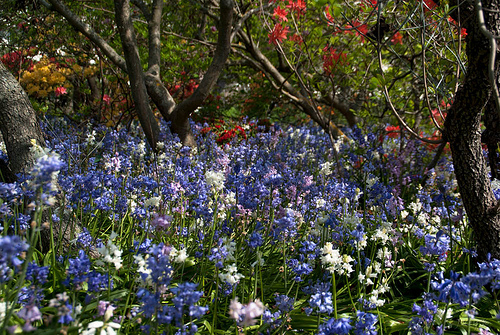

In [22]:
PIL.Image.open(str(tulips[1]))

## Keras 유틸리티를 사용하여 데이터 로드하기

다음으로, 유용한 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 디스크에서 이러한 이미지를 로드해 보겠습니다. 이러면 몇 줄의 코드로 디스크의 이미지 디렉터리에서 `tf.data.Dataset`로 이동하게 됩니다. 원하는 경우 [이미지 로드 및 전처리](../load_data/images.ipynb) 튜토리얼을 방문하여 처음부터 자체 데이터 로드 코드를 작성할 수도 있습니다.

### 데이터세트 만들기

로더에 대한 몇 가지 매개변수를 정의합니다.

In [9]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 이미지의 80%를 훈련에 사용하고 20%를 검증에 사용합니다.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다. 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 데이터 시각화하기

다음은 훈련 데이터세트의 처음 9개 이미지입니다.

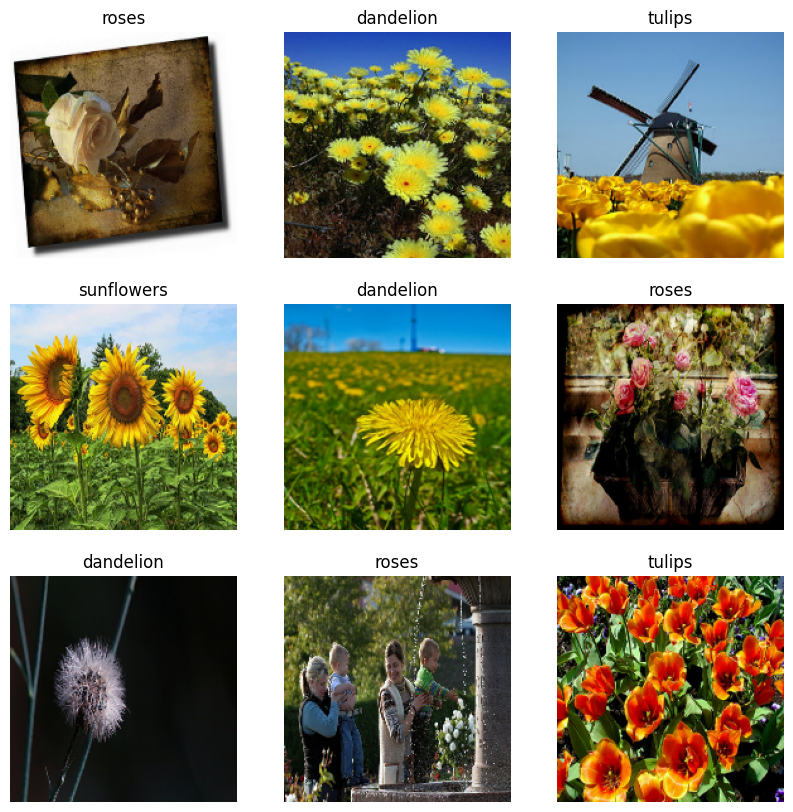

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이 튜토리얼의 뒷부분에서 훈련을 위해 이러한 데이터세트를 `Model.fit` 메서드에 전달합니다. 원하는 경우 데이터세트를 수동으로 반복하고 이미지 배치를 가져올 수도 있습니다.

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

`image_batch` 및 `labels_batch` 텐서에서 `.numpy()`를 호출하여 이를 `numpy.ndarray`로 변환할 수 있습니다.


## 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련하는 동안 데이터 전처리 및 모델 실행을 중첩시킵니다.

관심 있는 독자는 <a>tf.data API를 통한 성능 향상</a> 가이드의 <em>프리페치</em> 섹션에서 두 가지 메서드와 데이터를 디스크에 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 표준화하기

RGB 채널 값은 `[0, 255]` 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다.

여기에서 `tf.keras.layers.Rescaling`을 사용하여 값을 `[0, 1]` 범위로 표준화합니다.

In [16]:
normalization_layer = layers.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. `Dataset.map`을 호출하여 데이터세트에 이를 적용할 수 있습니다.

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 1.0


또는 모델 정의 내부에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기에서는 두 번째 접근 방식을 사용합니다.

참고: 이전에 `tf.keras.utils.image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 해당 모델에도 크기 조정 논리를 포함하려면 `tf.keras.layers.Resizing` 레이어를 사용할 수 있습니다.

## 기본 Keras 모델

### 모델 만들기

Keras [순차형](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 3개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)으로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다. 이 모델은 높은 정확도를 발휘하도록 조정되지 않았습니다. 이 튜토리얼의 목표는 표준 접근 방식을 보여주는 것입니다.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 모델 컴파일하기

이 튜토리얼에서는 `tf.keras.optimizers.Adam` 옵티마이저와 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달합니다.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 요약

Keras `Model.summary` 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [20]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d (Conv2D)             (None, 180, 180, 16)      448       


 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         


 )                                                               


 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         


 2D)                                                             


 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         


 2D)                                                             


 flatten (Flatten)           (None, 30976)             0         


 dense (Dense)               (None, 128)               3965056   


 dense_1 (Dense)             (None, 5)                 645       


Total params: 3,989,285


Trainable params: 3,989,285


Non-trainable params: 0


_________________________________________________________________


### 모델 훈련하기

Keras `Model.fit` 메서드를 사용하여 10 epoch 동안 모델을 훈련합니다.

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10



 1/92 [..............................] - ETA: 5:40 - loss: 1.6099 - accuracy: 0.2188


 5/92 [>.............................] - ETA: 1s - loss: 1.6463 - accuracy: 0.2688  


 9/92 [=>............................] - ETA: 1s - loss: 1.6305 - accuracy: 0.2361


13/92 [===>..........................] - ETA: 1s - loss: 1.6239 - accuracy: 0.2476


17/92 [====>.........................] - ETA: 1s - loss: 1.6180 - accuracy: 0.2721


21/92 [=====>........................] - ETA: 1s - loss: 1.6141 - accuracy: 0.2723


25/92 [=======>......................] - ETA: 0s - loss: 1.6092 - accuracy: 0.2650


27/92 [=======>......................] - ETA: 1s - loss: 1.6072 - accuracy: 0.2617


31/92 [=========>....................] - ETA: 0s - loss: 1.5996 - accuracy: 0.2591


35/92 [==========>...................] - ETA: 0s - loss: 1.5922 - accuracy: 0.2671


39/92 [===========>..................] - ETA: 0s - loss: 1.5810 - accuracy: 0.2766


43/92 [=============>................] - ETA: 0s - loss: 1.5675 - accuracy: 0.2895


47/92 [==============>...............] - ETA: 0s - loss: 1.5497 - accuracy: 0.3008


51/92 [===============>..............] - ETA: 0s - loss: 1.5391 - accuracy: 0.3054


55/92 [================>.............] - ETA: 0s - loss: 1.5260 - accuracy: 0.3145


59/92 [==================>...........] - ETA: 0s - loss: 1.5086 - accuracy: 0.3261


63/92 [===================>..........] - ETA: 0s - loss: 1.4941 - accuracy: 0.3332


67/92 [====================>.........] - ETA: 0s - loss: 1.4771 - accuracy: 0.3450


71/92 [======================>.......] - ETA: 0s - loss: 1.4631 - accuracy: 0.3542


75/92 [=======================>......] - ETA: 0s - loss: 1.4456 - accuracy: 0.3662


79/92 [========================>.....] - ETA: 0s - loss: 1.4354 - accuracy: 0.3730


83/92 [==========================>...] - ETA: 0s - loss: 1.4196 - accuracy: 0.3795


87/92 [===========================>..] - ETA: 0s - loss: 1.4115 - accuracy: 0.3876


91/92 [============================>.] - ETA: 0s - loss: 1.3993 - accuracy: 0.3939


92/92 [==============================] - 6s 20ms/step - loss: 1.3957 - accuracy: 0.3951 - val_loss: 1.1512 - val_accuracy: 0.5177


Epoch 2/10



 1/92 [..............................] - ETA: 1s - loss: 1.1357 - accuracy: 0.5312


 5/92 [>.............................] - ETA: 1s - loss: 1.1447 - accuracy: 0.5625


 9/92 [=>............................] - ETA: 1s - loss: 1.0912 - accuracy: 0.5868


13/92 [===>..........................] - ETA: 1s - loss: 1.0714 - accuracy: 0.5938


17/92 [====>.........................] - ETA: 1s - loss: 1.0941 - accuracy: 0.5735


21/92 [=====>........................] - ETA: 0s - loss: 1.0862 - accuracy: 0.5804


25/92 [=======>......................] - ETA: 0s - loss: 1.0786 - accuracy: 0.5763


29/92 [========>.....................] - ETA: 0s - loss: 1.0620 - accuracy: 0.5851


33/92 [=========>....................] - ETA: 0s - loss: 1.0719 - accuracy: 0.5758


37/92 [===========>..................] - ETA: 0s - loss: 1.0488 - accuracy: 0.5878


41/92 [============>.................] - ETA: 0s - loss: 1.0525 - accuracy: 0.5823


45/92 [=============>................] - ETA: 0s - loss: 1.0423 - accuracy: 0.5845


49/92 [==============>...............] - ETA: 0s - loss: 1.0310 - accuracy: 0.5936


53/92 [================>.............] - ETA: 0s - loss: 1.0240 - accuracy: 0.6001


57/92 [=================>............] - ETA: 0s - loss: 1.0203 - accuracy: 0.6024


61/92 [==================>...........] - ETA: 0s - loss: 1.0118 - accuracy: 0.6039


65/92 [====================>.........] - ETA: 0s - loss: 1.0083 - accuracy: 0.6057


69/92 [=====================>........] - ETA: 0s - loss: 1.0025 - accuracy: 0.6105


73/92 [======================>.......] - ETA: 0s - loss: 0.9959 - accuracy: 0.6108


77/92 [========================>.....] - ETA: 0s - loss: 0.9927 - accuracy: 0.6116


81/92 [=========================>....] - ETA: 0s - loss: 0.9910 - accuracy: 0.6126


85/92 [==========================>...] - ETA: 0s - loss: 0.9859 - accuracy: 0.6154


89/92 [============================>.] - ETA: 0s - loss: 0.9806 - accuracy: 0.6194


92/92 [==============================] - 1s 16ms/step - loss: 0.9742 - accuracy: 0.6219 - val_loss: 0.9448 - val_accuracy: 0.6471


Epoch 3/10



 1/92 [..............................] - ETA: 1s - loss: 0.9058 - accuracy: 0.6562


 5/92 [>.............................] - ETA: 1s - loss: 0.8435 - accuracy: 0.6750


 9/92 [=>............................] - ETA: 1s - loss: 0.7447 - accuracy: 0.7118


13/92 [===>..........................] - ETA: 1s - loss: 0.7306 - accuracy: 0.7260


17/92 [====>.........................] - ETA: 1s - loss: 0.7317 - accuracy: 0.7151


21/92 [=====>........................] - ETA: 0s - loss: 0.7421 - accuracy: 0.7188


25/92 [=======>......................] - ETA: 0s - loss: 0.7587 - accuracy: 0.7088


29/92 [========>.....................] - ETA: 0s - loss: 0.7452 - accuracy: 0.7112


33/92 [=========>....................] - ETA: 0s - loss: 0.7347 - accuracy: 0.7188


37/92 [===========>..................] - ETA: 0s - loss: 0.7490 - accuracy: 0.7103


41/92 [============>.................] - ETA: 0s - loss: 0.7526 - accuracy: 0.7096


45/92 [=============>................] - ETA: 0s - loss: 0.7544 - accuracy: 0.7104


49/92 [==============>...............] - ETA: 0s - loss: 0.7585 - accuracy: 0.7073


53/92 [================>.............] - ETA: 0s - loss: 0.7499 - accuracy: 0.7123


57/92 [=================>............] - ETA: 0s - loss: 0.7472 - accuracy: 0.7138


61/92 [==================>...........] - ETA: 0s - loss: 0.7480 - accuracy: 0.7121


65/92 [====================>.........] - ETA: 0s - loss: 0.7379 - accuracy: 0.7168


69/92 [=====================>........] - ETA: 0s - loss: 0.7401 - accuracy: 0.7147


73/92 [======================>.......] - ETA: 0s - loss: 0.7360 - accuracy: 0.7169


77/92 [========================>.....] - ETA: 0s - loss: 0.7422 - accuracy: 0.7162


81/92 [=========================>....] - ETA: 0s - loss: 0.7484 - accuracy: 0.7128


85/92 [==========================>...] - ETA: 0s - loss: 0.7438 - accuracy: 0.7168


89/92 [============================>.] - ETA: 0s - loss: 0.7453 - accuracy: 0.7162


92/92 [==============================] - 1s 16ms/step - loss: 0.7430 - accuracy: 0.7170 - val_loss: 0.9100 - val_accuracy: 0.6649


Epoch 4/10



 1/92 [..............................] - ETA: 1s - loss: 0.6436 - accuracy: 0.8125


 5/92 [>.............................] - ETA: 1s - loss: 0.5479 - accuracy: 0.8375


 9/92 [=>............................] - ETA: 1s - loss: 0.5883 - accuracy: 0.8056


13/92 [===>..........................] - ETA: 1s - loss: 0.5669 - accuracy: 0.8173


17/92 [====>.........................] - ETA: 1s - loss: 0.5288 - accuracy: 0.8290


21/92 [=====>........................] - ETA: 0s - loss: 0.5107 - accuracy: 0.8304


25/92 [=======>......................] - ETA: 0s - loss: 0.5085 - accuracy: 0.8325


29/92 [========>.....................] - ETA: 0s - loss: 0.4915 - accuracy: 0.8416


33/92 [=========>....................] - ETA: 0s - loss: 0.4795 - accuracy: 0.8428


37/92 [===========>..................] - ETA: 0s - loss: 0.4729 - accuracy: 0.8429


41/92 [============>.................] - ETA: 0s - loss: 0.4718 - accuracy: 0.8422


45/92 [=============>................] - ETA: 0s - loss: 0.4687 - accuracy: 0.8431


49/92 [==============>...............] - ETA: 0s - loss: 0.4762 - accuracy: 0.8386


53/92 [================>.............] - ETA: 0s - loss: 0.4907 - accuracy: 0.8331


57/92 [=================>............] - ETA: 0s - loss: 0.4895 - accuracy: 0.8311


61/92 [==================>...........] - ETA: 0s - loss: 0.4876 - accuracy: 0.8315


65/92 [====================>.........] - ETA: 0s - loss: 0.4906 - accuracy: 0.8279


69/92 [=====================>........] - ETA: 0s - loss: 0.4922 - accuracy: 0.8270


73/92 [======================>.......] - ETA: 0s - loss: 0.4930 - accuracy: 0.8258


77/92 [========================>.....] - ETA: 0s - loss: 0.4926 - accuracy: 0.8263


81/92 [=========================>....] - ETA: 0s - loss: 0.4896 - accuracy: 0.8278


85/92 [==========================>...] - ETA: 0s - loss: 0.4874 - accuracy: 0.8289


89/92 [============================>.] - ETA: 0s - loss: 0.4902 - accuracy: 0.8275


92/92 [==============================] - 1s 16ms/step - loss: 0.4913 - accuracy: 0.8266 - val_loss: 1.1012 - val_accuracy: 0.6335


Epoch 5/10



 1/92 [..............................] - ETA: 1s - loss: 0.6939 - accuracy: 0.7500


 5/92 [>.............................] - ETA: 1s - loss: 0.5239 - accuracy: 0.8000


 9/92 [=>............................] - ETA: 1s - loss: 0.4351 - accuracy: 0.8438


13/92 [===>..........................] - ETA: 1s - loss: 0.3777 - accuracy: 0.8726


17/92 [====>.........................] - ETA: 1s - loss: 0.3690 - accuracy: 0.8787


21/92 [=====>........................] - ETA: 0s - loss: 0.3458 - accuracy: 0.8795


25/92 [=======>......................] - ETA: 0s - loss: 0.3501 - accuracy: 0.8725


29/92 [========>.....................] - ETA: 0s - loss: 0.3462 - accuracy: 0.8793


33/92 [=========>....................] - ETA: 0s - loss: 0.3350 - accuracy: 0.8854


37/92 [===========>..................] - ETA: 0s - loss: 0.3334 - accuracy: 0.8851


41/92 [============>.................] - ETA: 0s - loss: 0.3310 - accuracy: 0.8857


45/92 [=============>................] - ETA: 0s - loss: 0.3273 - accuracy: 0.8882


49/92 [==============>...............] - ETA: 0s - loss: 0.3229 - accuracy: 0.8897


53/92 [================>.............] - ETA: 0s - loss: 0.3155 - accuracy: 0.8922


57/92 [=================>............] - ETA: 0s - loss: 0.3126 - accuracy: 0.8921


61/92 [==================>...........] - ETA: 0s - loss: 0.3110 - accuracy: 0.8920


65/92 [====================>.........] - ETA: 0s - loss: 0.3138 - accuracy: 0.8924


69/92 [=====================>........] - ETA: 0s - loss: 0.3148 - accuracy: 0.8918


73/92 [======================>.......] - ETA: 0s - loss: 0.3178 - accuracy: 0.8918


77/92 [========================>.....] - ETA: 0s - loss: 0.3223 - accuracy: 0.8901


81/92 [=========================>....] - ETA: 0s - loss: 0.3221 - accuracy: 0.8909


85/92 [==========================>...] - ETA: 0s - loss: 0.3258 - accuracy: 0.8886


89/92 [============================>.] - ETA: 0s - loss: 0.3280 - accuracy: 0.8873


92/92 [==============================] - 1s 16ms/step - loss: 0.3285 - accuracy: 0.8869 - val_loss: 1.1343 - val_accuracy: 0.6213


Epoch 6/10



 1/92 [..............................] - ETA: 1s - loss: 0.3701 - accuracy: 0.8438


 5/92 [>.............................] - ETA: 1s - loss: 0.2315 - accuracy: 0.9250


 9/92 [=>............................] - ETA: 1s - loss: 0.2517 - accuracy: 0.9410


13/92 [===>..........................] - ETA: 1s - loss: 0.2354 - accuracy: 0.9447


17/92 [====>.........................] - ETA: 1s - loss: 0.2141 - accuracy: 0.9540


21/92 [=====>........................] - ETA: 0s - loss: 0.2248 - accuracy: 0.9435


25/92 [=======>......................] - ETA: 0s - loss: 0.2123 - accuracy: 0.9488


29/92 [========>.....................] - ETA: 0s - loss: 0.2097 - accuracy: 0.9472


33/92 [=========>....................] - ETA: 0s - loss: 0.2016 - accuracy: 0.9470


37/92 [===========>..................] - ETA: 0s - loss: 0.1948 - accuracy: 0.9493


41/92 [============>.................] - ETA: 0s - loss: 0.1975 - accuracy: 0.9459


45/92 [=============>................] - ETA: 0s - loss: 0.1927 - accuracy: 0.9479


49/92 [==============>...............] - ETA: 0s - loss: 0.1918 - accuracy: 0.9458


53/92 [================>.............] - ETA: 0s - loss: 0.1903 - accuracy: 0.9452


57/92 [=================>............] - ETA: 0s - loss: 0.1835 - accuracy: 0.9477


61/92 [==================>...........] - ETA: 0s - loss: 0.1774 - accuracy: 0.9501


65/92 [====================>.........] - ETA: 0s - loss: 0.1728 - accuracy: 0.9503


69/92 [=====================>........] - ETA: 0s - loss: 0.1704 - accuracy: 0.9518


73/92 [======================>.......] - ETA: 0s - loss: 0.1693 - accuracy: 0.9527


77/92 [========================>.....] - ETA: 0s - loss: 0.1688 - accuracy: 0.9524


81/92 [=========================>....] - ETA: 0s - loss: 0.1690 - accuracy: 0.9524


85/92 [==========================>...] - ETA: 0s - loss: 0.1693 - accuracy: 0.9517


89/92 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9514


92/92 [==============================] - 1s 16ms/step - loss: 0.1728 - accuracy: 0.9499 - val_loss: 1.3179 - val_accuracy: 0.6499


Epoch 7/10



 1/92 [..............................] - ETA: 1s - loss: 0.0563 - accuracy: 1.0000


 5/92 [>.............................] - ETA: 1s - loss: 0.0801 - accuracy: 0.9812


 9/92 [=>............................] - ETA: 1s - loss: 0.0846 - accuracy: 0.9792


13/92 [===>..........................] - ETA: 1s - loss: 0.0754 - accuracy: 0.9856


17/92 [====>.........................] - ETA: 1s - loss: 0.0766 - accuracy: 0.9853


21/92 [=====>........................] - ETA: 0s - loss: 0.0861 - accuracy: 0.9807


25/92 [=======>......................] - ETA: 0s - loss: 0.0794 - accuracy: 0.9812


29/92 [========>.....................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9784


33/92 [=========>....................] - ETA: 0s - loss: 0.0877 - accuracy: 0.9773


37/92 [===========>..................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9755


41/92 [============>.................] - ETA: 0s - loss: 0.0868 - accuracy: 0.9764


45/92 [=============>................] - ETA: 0s - loss: 0.0851 - accuracy: 0.9771


49/92 [==============>...............] - ETA: 0s - loss: 0.0855 - accuracy: 0.9770


53/92 [================>.............] - ETA: 0s - loss: 0.0841 - accuracy: 0.9776


57/92 [=================>............] - ETA: 0s - loss: 0.0830 - accuracy: 0.9770


61/92 [==================>...........] - ETA: 0s - loss: 0.0820 - accuracy: 0.9775


65/92 [====================>.........] - ETA: 0s - loss: 0.0826 - accuracy: 0.9774


69/92 [=====================>........] - ETA: 0s - loss: 0.0814 - accuracy: 0.9778


73/92 [======================>.......] - ETA: 0s - loss: 0.0819 - accuracy: 0.9769


77/92 [========================>.....] - ETA: 0s - loss: 0.0861 - accuracy: 0.9748


81/92 [=========================>....] - ETA: 0s - loss: 0.0876 - accuracy: 0.9745


85/92 [==========================>...] - ETA: 0s - loss: 0.0892 - accuracy: 0.9738


89/92 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9743


92/92 [==============================] - 1s 16ms/step - loss: 0.0916 - accuracy: 0.9745 - val_loss: 1.5168 - val_accuracy: 0.6390


Epoch 8/10



 1/92 [..............................] - ETA: 1s - loss: 0.1445 - accuracy: 0.9375


 5/92 [>.............................] - ETA: 1s - loss: 0.0888 - accuracy: 0.9750


 9/92 [=>............................] - ETA: 1s - loss: 0.0970 - accuracy: 0.9722


13/92 [===>..........................] - ETA: 1s - loss: 0.0956 - accuracy: 0.9688


17/92 [====>.........................] - ETA: 1s - loss: 0.0946 - accuracy: 0.9669


21/92 [=====>........................] - ETA: 0s - loss: 0.0870 - accuracy: 0.9717


25/92 [=======>......................] - ETA: 0s - loss: 0.0877 - accuracy: 0.9725


29/92 [========>.....................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9741


33/92 [=========>....................] - ETA: 0s - loss: 0.0854 - accuracy: 0.9725


37/92 [===========>..................] - ETA: 0s - loss: 0.0804 - accuracy: 0.9745


41/92 [============>.................] - ETA: 0s - loss: 0.0786 - accuracy: 0.9747


45/92 [=============>................] - ETA: 0s - loss: 0.0768 - accuracy: 0.9763


49/92 [==============>...............] - ETA: 0s - loss: 0.0803 - accuracy: 0.9763


53/92 [================>.............] - ETA: 0s - loss: 0.0854 - accuracy: 0.9733


57/92 [=================>............] - ETA: 0s - loss: 0.0864 - accuracy: 0.9736


61/92 [==================>...........] - ETA: 0s - loss: 0.0864 - accuracy: 0.9733


65/92 [====================>.........] - ETA: 0s - loss: 0.0845 - accuracy: 0.9739


69/92 [=====================>........] - ETA: 0s - loss: 0.0852 - accuracy: 0.9741


73/92 [======================>.......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9747


77/92 [========================>.....] - ETA: 0s - loss: 0.0824 - accuracy: 0.9752


81/92 [=========================>....] - ETA: 0s - loss: 0.0835 - accuracy: 0.9745


85/92 [==========================>...] - ETA: 0s - loss: 0.0868 - accuracy: 0.9731


89/92 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9718


92/92 [==============================] - 1s 16ms/step - loss: 0.0915 - accuracy: 0.9714 - val_loss: 1.8044 - val_accuracy: 0.6158


Epoch 9/10



 1/92 [..............................] - ETA: 1s - loss: 0.0935 - accuracy: 1.0000


 5/92 [>.............................] - ETA: 1s - loss: 0.0468 - accuracy: 0.9937


 9/92 [=>............................] - ETA: 1s - loss: 0.0555 - accuracy: 0.9896


13/92 [===>..........................] - ETA: 1s - loss: 0.0600 - accuracy: 0.9856


17/92 [====>.........................] - ETA: 1s - loss: 0.0544 - accuracy: 0.9871


21/92 [=====>........................] - ETA: 1s - loss: 0.0547 - accuracy: 0.9851


25/92 [=======>......................] - ETA: 0s - loss: 0.0516 - accuracy: 0.9862


29/92 [========>.....................] - ETA: 0s - loss: 0.0494 - accuracy: 0.9881


33/92 [=========>....................] - ETA: 0s - loss: 0.0469 - accuracy: 0.9896


37/92 [===========>..................] - ETA: 0s - loss: 0.0459 - accuracy: 0.9899


41/92 [============>.................] - ETA: 0s - loss: 0.0447 - accuracy: 0.9901


45/92 [=============>................] - ETA: 0s - loss: 0.0445 - accuracy: 0.9896


49/92 [==============>...............] - ETA: 0s - loss: 0.0429 - accuracy: 0.9898


53/92 [================>.............] - ETA: 0s - loss: 0.0408 - accuracy: 0.9906


57/92 [=================>............] - ETA: 0s - loss: 0.0419 - accuracy: 0.9901


61/92 [==================>...........] - ETA: 0s - loss: 0.0415 - accuracy: 0.9898


65/92 [====================>.........] - ETA: 0s - loss: 0.0409 - accuracy: 0.9894


69/92 [=====================>........] - ETA: 0s - loss: 0.0409 - accuracy: 0.9896


73/92 [======================>.......] - ETA: 0s - loss: 0.0396 - accuracy: 0.9901


77/92 [========================>.....] - ETA: 0s - loss: 0.0380 - accuracy: 0.9906


81/92 [=========================>....] - ETA: 0s - loss: 0.0386 - accuracy: 0.9903


85/92 [==========================>...] - ETA: 0s - loss: 0.0386 - accuracy: 0.9900


89/92 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9901


92/92 [==============================] - 1s 16ms/step - loss: 0.0383 - accuracy: 0.9901 - val_loss: 1.9946 - val_accuracy: 0.6076


Epoch 10/10



 1/92 [..............................] - ETA: 1s - loss: 0.0150 - accuracy: 1.0000


 5/92 [>.............................] - ETA: 1s - loss: 0.0077 - accuracy: 1.0000


 9/92 [=>............................] - ETA: 1s - loss: 0.0145 - accuracy: 0.9965


13/92 [===>..........................] - ETA: 1s - loss: 0.0128 - accuracy: 0.9976


17/92 [====>.........................] - ETA: 1s - loss: 0.0144 - accuracy: 0.9963


21/92 [=====>........................] - ETA: 0s - loss: 0.0275 - accuracy: 0.9926


25/92 [=======>......................] - ETA: 0s - loss: 0.0329 - accuracy: 0.9912


29/92 [========>.....................] - ETA: 0s - loss: 0.0347 - accuracy: 0.9914


33/92 [=========>....................] - ETA: 0s - loss: 0.0343 - accuracy: 0.9915


37/92 [===========>..................] - ETA: 0s - loss: 0.0352 - accuracy: 0.9915


41/92 [============>.................] - ETA: 0s - loss: 0.0356 - accuracy: 0.9916


45/92 [=============>................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9923


49/92 [==============>...............] - ETA: 0s - loss: 0.0356 - accuracy: 0.9923


53/92 [================>.............] - ETA: 0s - loss: 0.0342 - accuracy: 0.9929


57/92 [=================>............] - ETA: 0s - loss: 0.0326 - accuracy: 0.9934


61/92 [==================>...........] - ETA: 0s - loss: 0.0330 - accuracy: 0.9923


65/92 [====================>.........] - ETA: 0s - loss: 0.0333 - accuracy: 0.9923


69/92 [=====================>........] - ETA: 0s - loss: 0.0336 - accuracy: 0.9923


73/92 [======================>.......] - ETA: 0s - loss: 0.0351 - accuracy: 0.9914


77/92 [========================>.....] - ETA: 0s - loss: 0.0395 - accuracy: 0.9906


81/92 [=========================>....] - ETA: 0s - loss: 0.0423 - accuracy: 0.9892


85/92 [==========================>...] - ETA: 0s - loss: 0.0430 - accuracy: 0.9893


89/92 [============================>.] - ETA: 0s - loss: 0.0483 - accuracy: 0.9880


92/92 [==============================] - 1s 16ms/step - loss: 0.0495 - accuracy: 0.9877 - val_loss: 1.9917 - val_accuracy: 0.5913


## 훈련 결과 시각화하기

훈련 및 검증 세트에 대한 손실과 정확성 플롯을 생성합니다.

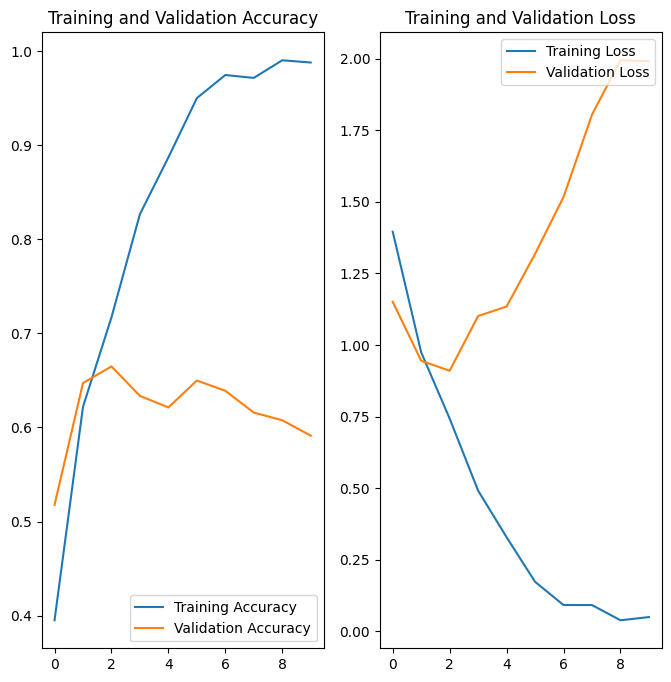

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

플롯은 훈련 정확도와 검증 정확도가 큰 차이로 떨어져 있으며 모델은 검증 세트에서 약 60%의 정확도만을 달성했음을 보여줍니다.

다음 튜토리얼 섹션에서는 무엇이 잘못되었는지 검사하고 모델의 전체 성능을 높이는 방법을 보여줍니다.

## 과대적합

위의 플롯에서 훈련 정확성은 시간이 지남에 따라 선형적으로 증가하는 반면, 검증 정확성은 훈련 과정에서 약 60%를 벗어나지 못합니다. 또한 훈련 정확성과 검증 정확성 간의 정확성 차이가 상당한데, 이는 [과대적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)의 징후입니다.

훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원치 않는 세부까지 학습합니다. 이 현상을 과대적합이라고 합니다. 이는 모델이 새 데이터세트에서 일반화하는 데 어려움이 있음을 의미합니다.

훈련 과정에서 과대적합을 막는 여러 가지 방법들이 있습니다. 이 튜토리얼에서는 *데이터 증강*을 사용하고 모델에 *드롭아웃*을 추가합니다.

## 데이터 증강

과대적합은 일반적으로 훈련 예제가 적을 때 발생합니다. [데이터 증강](./data_augmentation.ipynb)은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다. 그러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워집니다.

Keras 전처리 레이어 `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, `tf.keras.layers.RandomZoom`을 사용하여 데이터 증강을 구현합니다. 다른 레이어처럼 이를 모델 내부에 포함시키고 GPU에서 실행할 수 있습니다.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강 예제를 시각화합니다.

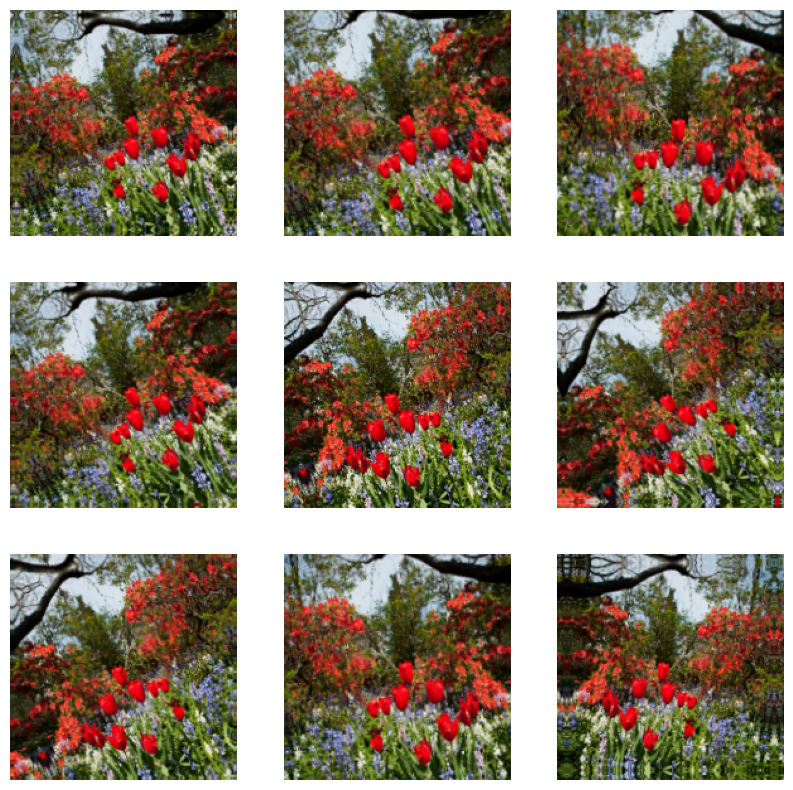

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

다음 단계에서 훈련하기 전에 모델에 데이터 증강을 추가합니다.

## 드롭아웃

과대적합을 줄이는 또 다른 기술은 네트워크에 [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} 정규화를 도입하는 것입니다.

드롭아웃을 레이어에 적용하면, 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃됩니다(활성화를 0으로 설정). 드롭아웃은 0.1, 0.2, 0.4 등의 형식으로 소수를 입력 값으로 사용합니다. 이는 적용된 레이어에서 출력 단위의 10%, 20% 또는 40%를 임의로 제거하는 것을 의미합니다.

증강 이미지를 사용하여 훈련하기 전에 `tf.keras.layers.Dropout`을 사용하여 새로운 신경망을 생성합니다.

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## 모델 컴파일 및 훈련하기

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential_1 (Sequential)   (None, 180, 180, 3)       0         


 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       


 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         


 2D)                                                             


 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         


 2D)                                                             


 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_5 (MaxPooling  (None, 22, 22, 64)       0         


 2D)                                                             


 dropout (Dropout)           (None, 22, 22, 64)        0         


 flatten_1 (Flatten)         (None, 30976)             0         


 dense_2 (Dense)             (None, 128)               3965056   


 outputs (Dense)             (None, 5)                 645       


Total params: 3,989,285


Trainable params: 3,989,285


Non-trainable params: 0


_________________________________________________________________


In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2022-12-15 01:27:19.861955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



 1/92 [..............................] - ETA: 6:23 - loss: 1.6157 - accuracy: 0.2812


 2/92 [..............................] - ETA: 7s - loss: 1.7291 - accuracy: 0.2812  


 3/92 [..............................] - ETA: 7s - loss: 1.7998 - accuracy: 0.2292


 4/92 [>.............................] - ETA: 7s - loss: 1.7370 - accuracy: 0.2656


 5/92 [>.............................] - ETA: 7s - loss: 1.7042 - accuracy: 0.2688


 6/92 [>.............................] - ETA: 7s - loss: 1.6758 - accuracy: 0.2604


 7/92 [=>............................] - ETA: 7s - loss: 1.6770 - accuracy: 0.2545


 8/92 [=>............................] - ETA: 7s - loss: 1.6623 - accuracy: 0.2656


 9/92 [=>............................] - ETA: 7s - loss: 1.6660 - accuracy: 0.2604


10/92 [==>...........................] - ETA: 7s - loss: 1.6554 - accuracy: 0.2688


11/92 [==>...........................] - ETA: 7s - loss: 1.6422 - accuracy: 0.2784


12/92 [==>...........................] - ETA: 7s - loss: 1.6332 - accuracy: 0.2786


13/92 [===>..........................] - ETA: 6s - loss: 1.6264 - accuracy: 0.2788


14/92 [===>..........................] - ETA: 6s - loss: 1.6153 - accuracy: 0.2857


15/92 [===>..........................] - ETA: 6s - loss: 1.6015 - accuracy: 0.2937


16/92 [====>.........................] - ETA: 6s - loss: 1.5950 - accuracy: 0.2949


17/92 [====>.........................] - ETA: 6s - loss: 1.5919 - accuracy: 0.2923


18/92 [====>.........................] - ETA: 6s - loss: 1.5934 - accuracy: 0.2865


19/92 [=====>........................] - ETA: 6s - loss: 1.5881 - accuracy: 0.2862


20/92 [=====>........................] - ETA: 6s - loss: 1.5839 - accuracy: 0.2781


21/92 [=====>........................] - ETA: 6s - loss: 1.5807 - accuracy: 0.2696


22/92 [======>.......................] - ETA: 6s - loss: 1.5781 - accuracy: 0.2658


23/92 [======>.......................] - ETA: 6s - loss: 1.5731 - accuracy: 0.2692


24/92 [======>.......................] - ETA: 5s - loss: 1.5599 - accuracy: 0.2750


25/92 [=======>......................] - ETA: 5s - loss: 1.5543 - accuracy: 0.2790


26/92 [=======>......................] - ETA: 5s - loss: 1.5504 - accuracy: 0.2791


27/92 [=======>......................] - ETA: 5s - loss: 1.5424 - accuracy: 0.2804


28/92 [========>.....................] - ETA: 5s - loss: 1.5394 - accuracy: 0.2894


29/92 [========>.....................] - ETA: 5s - loss: 1.5296 - accuracy: 0.2935


30/92 [========>.....................] - ETA: 5s - loss: 1.5239 - accuracy: 0.2973


31/92 [=========>....................] - ETA: 5s - loss: 1.5167 - accuracy: 0.2998


32/92 [=========>....................] - ETA: 5s - loss: 1.5134 - accuracy: 0.3022


33/92 [=========>....................] - ETA: 5s - loss: 1.5136 - accuracy: 0.3044


34/92 [==========>...................] - ETA: 5s - loss: 1.5177 - accuracy: 0.3074


35/92 [==========>...................] - ETA: 5s - loss: 1.5106 - accuracy: 0.3129


36/92 [==========>...................] - ETA: 4s - loss: 1.5051 - accuracy: 0.3156


37/92 [===========>..................] - ETA: 4s - loss: 1.4974 - accuracy: 0.3214


38/92 [===========>..................] - ETA: 4s - loss: 1.4869 - accuracy: 0.3278


39/92 [===========>..................] - ETA: 4s - loss: 1.4861 - accuracy: 0.3258


40/92 [============>.................] - ETA: 4s - loss: 1.4786 - accuracy: 0.3286


41/92 [============>.................] - ETA: 4s - loss: 1.4709 - accuracy: 0.3336


42/92 [============>.................] - ETA: 4s - loss: 1.4642 - accuracy: 0.3391


43/92 [=============>................] - ETA: 4s - loss: 1.4610 - accuracy: 0.3421


44/92 [=============>................] - ETA: 4s - loss: 1.4525 - accuracy: 0.3486


45/92 [=============>................] - ETA: 4s - loss: 1.4439 - accuracy: 0.3527


46/92 [==============>...............] - ETA: 4s - loss: 1.4411 - accuracy: 0.3545


47/92 [==============>...............] - ETA: 3s - loss: 1.4349 - accuracy: 0.3576


48/92 [==============>...............] - ETA: 3s - loss: 1.4349 - accuracy: 0.3593


49/92 [==============>...............] - ETA: 3s - loss: 1.4264 - accuracy: 0.3647


50/92 [===============>..............] - ETA: 3s - loss: 1.4228 - accuracy: 0.3668


51/92 [===============>..............] - ETA: 3s - loss: 1.4219 - accuracy: 0.3676


52/92 [===============>..............] - ETA: 3s - loss: 1.4158 - accuracy: 0.3708


53/92 [================>.............] - ETA: 3s - loss: 1.4074 - accuracy: 0.3744


54/92 [================>.............] - ETA: 3s - loss: 1.4010 - accuracy: 0.3785


55/92 [================>.............] - ETA: 3s - loss: 1.3976 - accuracy: 0.3836


56/92 [=================>............] - ETA: 3s - loss: 1.3921 - accuracy: 0.3873


57/92 [=================>............] - ETA: 3s - loss: 1.3878 - accuracy: 0.3882


58/92 [=================>............] - ETA: 3s - loss: 1.3843 - accuracy: 0.3912


59/92 [==================>...........] - ETA: 2s - loss: 1.3819 - accuracy: 0.3926


60/92 [==================>...........] - ETA: 2s - loss: 1.3793 - accuracy: 0.3933


61/92 [==================>...........] - ETA: 2s - loss: 1.3747 - accuracy: 0.3935


62/92 [===================>..........] - ETA: 2s - loss: 1.3689 - accuracy: 0.3963


63/92 [===================>..........] - ETA: 2s - loss: 1.3650 - accuracy: 0.3979


64/92 [===================>..........] - ETA: 2s - loss: 1.3618 - accuracy: 0.3980


65/92 [====================>.........] - ETA: 2s - loss: 1.3572 - accuracy: 0.4006


66/92 [====================>.........] - ETA: 2s - loss: 1.3542 - accuracy: 0.4002


67/92 [====================>.........] - ETA: 2s - loss: 1.3518 - accuracy: 0.4026


68/92 [=====================>........] - ETA: 2s - loss: 1.3458 - accuracy: 0.4059


69/92 [=====================>........] - ETA: 2s - loss: 1.3421 - accuracy: 0.4077


70/92 [=====================>........] - ETA: 1s - loss: 1.3373 - accuracy: 0.4113


71/92 [======================>.......] - ETA: 1s - loss: 1.3356 - accuracy: 0.4125


72/92 [======================>.......] - ETA: 1s - loss: 1.3392 - accuracy: 0.4125


73/92 [======================>.......] - ETA: 1s - loss: 1.3327 - accuracy: 0.4167


74/92 [=======================>......] - ETA: 1s - loss: 1.3337 - accuracy: 0.4174


75/92 [=======================>......] - ETA: 1s - loss: 1.3332 - accuracy: 0.4168


76/92 [=======================>......] - ETA: 1s - loss: 1.3337 - accuracy: 0.4191


77/92 [========================>.....] - ETA: 1s - loss: 1.3292 - accuracy: 0.4218


78/92 [========================>.....] - ETA: 1s - loss: 1.3250 - accuracy: 0.4248


79/92 [========================>.....] - ETA: 1s - loss: 1.3233 - accuracy: 0.4250


80/92 [=========================>....] - ETA: 1s - loss: 1.3209 - accuracy: 0.4259


81/92 [=========================>....] - ETA: 0s - loss: 1.3177 - accuracy: 0.4272


82/92 [=========================>....] - ETA: 0s - loss: 1.3141 - accuracy: 0.4297


83/92 [==========================>...] - ETA: 0s - loss: 1.3103 - accuracy: 0.4328


84/92 [==========================>...] - ETA: 0s - loss: 1.3089 - accuracy: 0.4343


85/92 [==========================>...] - ETA: 0s - loss: 1.3066 - accuracy: 0.4347


86/92 [===========================>..] - ETA: 0s - loss: 1.3026 - accuracy: 0.4355


87/92 [===========================>..] - ETA: 0s - loss: 1.3025 - accuracy: 0.4348


88/92 [===========================>..] - ETA: 0s - loss: 1.3003 - accuracy: 0.4359


89/92 [============================>.] - ETA: 0s - loss: 1.2971 - accuracy: 0.4370


90/92 [============================>.] - ETA: 0s - loss: 1.2966 - accuracy: 0.4373


91/92 [============================>.] - ETA: 0s - loss: 1.2918 - accuracy: 0.4408


92/92 [==============================] - ETA: 0s - loss: 1.2884 - accuracy: 0.4431


92/92 [==============================] - 13s 93ms/step - loss: 1.2884 - accuracy: 0.4431 - val_loss: 1.0855 - val_accuracy: 0.5763


Epoch 2/15



 1/92 [..............................] - ETA: 7s - loss: 1.0367 - accuracy: 0.6562


 2/92 [..............................] - ETA: 8s - loss: 0.9705 - accuracy: 0.6719


 3/92 [..............................] - ETA: 8s - loss: 0.9657 - accuracy: 0.6771


 4/92 [>.............................] - ETA: 8s - loss: 0.9492 - accuracy: 0.6797


 5/92 [>.............................] - ETA: 7s - loss: 0.9757 - accuracy: 0.6438


 6/92 [>.............................] - ETA: 7s - loss: 1.0211 - accuracy: 0.6458


 7/92 [=>............................] - ETA: 7s - loss: 0.9900 - accuracy: 0.6518


 8/92 [=>............................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6367


 9/92 [=>............................] - ETA: 7s - loss: 0.9689 - accuracy: 0.6389


10/92 [==>...........................] - ETA: 7s - loss: 0.9722 - accuracy: 0.6375


11/92 [==>...........................] - ETA: 7s - loss: 0.9651 - accuracy: 0.6364


12/92 [==>...........................] - ETA: 7s - loss: 0.9664 - accuracy: 0.6328


13/92 [===>..........................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6250


14/92 [===>..........................] - ETA: 6s - loss: 0.9979 - accuracy: 0.6228


15/92 [===>..........................] - ETA: 6s - loss: 0.9922 - accuracy: 0.6271


16/92 [====>.........................] - ETA: 6s - loss: 0.9978 - accuracy: 0.6250


17/92 [====>.........................] - ETA: 6s - loss: 0.9874 - accuracy: 0.6305


18/92 [====>.........................] - ETA: 6s - loss: 0.9858 - accuracy: 0.6302


19/92 [=====>........................] - ETA: 6s - loss: 0.9923 - accuracy: 0.6250


20/92 [=====>........................] - ETA: 6s - loss: 0.9988 - accuracy: 0.6219


21/92 [=====>........................] - ETA: 6s - loss: 0.9979 - accuracy: 0.6220


22/92 [======>.......................] - ETA: 6s - loss: 0.9981 - accuracy: 0.6278


23/92 [======>.......................] - ETA: 6s - loss: 1.0022 - accuracy: 0.6236


24/92 [======>.......................] - ETA: 6s - loss: 1.0045 - accuracy: 0.6250


25/92 [=======>......................] - ETA: 5s - loss: 1.0015 - accuracy: 0.6250


26/92 [=======>......................] - ETA: 5s - loss: 1.0017 - accuracy: 0.6214


27/92 [=======>......................] - ETA: 5s - loss: 1.0011 - accuracy: 0.6215


28/92 [========>.....................] - ETA: 5s - loss: 1.0019 - accuracy: 0.6228


29/92 [========>.....................] - ETA: 5s - loss: 1.0075 - accuracy: 0.6196


30/92 [========>.....................] - ETA: 5s - loss: 1.0085 - accuracy: 0.6167


31/92 [=========>....................] - ETA: 5s - loss: 1.0032 - accuracy: 0.6200


32/92 [=========>....................] - ETA: 5s - loss: 1.0094 - accuracy: 0.6152


33/92 [=========>....................] - ETA: 5s - loss: 1.0088 - accuracy: 0.6146


34/92 [==========>...................] - ETA: 5s - loss: 1.0136 - accuracy: 0.6103


35/92 [==========>...................] - ETA: 5s - loss: 1.0101 - accuracy: 0.6098


36/92 [==========>...................] - ETA: 5s - loss: 1.0226 - accuracy: 0.6007


37/92 [===========>..................] - ETA: 4s - loss: 1.0244 - accuracy: 0.5997


38/92 [===========>..................] - ETA: 4s - loss: 1.0269 - accuracy: 0.5995


39/92 [===========>..................] - ETA: 4s - loss: 1.0275 - accuracy: 0.5978


40/92 [============>.................] - ETA: 4s - loss: 1.0296 - accuracy: 0.5945


41/92 [============>.................] - ETA: 4s - loss: 1.0313 - accuracy: 0.5930


42/92 [============>.................] - ETA: 4s - loss: 1.0332 - accuracy: 0.5915


43/92 [=============>................] - ETA: 4s - loss: 1.0325 - accuracy: 0.5894


44/92 [=============>................] - ETA: 4s - loss: 1.0317 - accuracy: 0.5923


45/92 [=============>................] - ETA: 4s - loss: 1.0317 - accuracy: 0.5910


46/92 [==============>...............] - ETA: 4s - loss: 1.0269 - accuracy: 0.5924


47/92 [==============>...............] - ETA: 4s - loss: 1.0253 - accuracy: 0.5931


48/92 [==============>...............] - ETA: 3s - loss: 1.0209 - accuracy: 0.5951


49/92 [==============>...............] - ETA: 3s - loss: 1.0228 - accuracy: 0.5938


50/92 [===============>..............] - ETA: 3s - loss: 1.0187 - accuracy: 0.5956


51/92 [===============>..............] - ETA: 3s - loss: 1.0199 - accuracy: 0.5944


52/92 [===============>..............] - ETA: 3s - loss: 1.0171 - accuracy: 0.5950


53/92 [================>.............] - ETA: 3s - loss: 1.0165 - accuracy: 0.5938


54/92 [================>.............] - ETA: 3s - loss: 1.0166 - accuracy: 0.5938


55/92 [================>.............] - ETA: 3s - loss: 1.0176 - accuracy: 0.5932


56/92 [=================>............] - ETA: 3s - loss: 1.0179 - accuracy: 0.5915


57/92 [=================>............] - ETA: 3s - loss: 1.0190 - accuracy: 0.5927


58/92 [=================>............] - ETA: 3s - loss: 1.0129 - accuracy: 0.5948


59/92 [==================>...........] - ETA: 2s - loss: 1.0133 - accuracy: 0.5959


60/92 [==================>...........] - ETA: 2s - loss: 1.0148 - accuracy: 0.5953


61/92 [==================>...........] - ETA: 2s - loss: 1.0173 - accuracy: 0.5963


62/92 [===================>..........] - ETA: 2s - loss: 1.0173 - accuracy: 0.5988


63/92 [===================>..........] - ETA: 2s - loss: 1.0123 - accuracy: 0.6007


64/92 [===================>..........] - ETA: 2s - loss: 1.0103 - accuracy: 0.6021


65/92 [====================>.........] - ETA: 2s - loss: 1.0105 - accuracy: 0.6005


66/92 [====================>.........] - ETA: 2s - loss: 1.0095 - accuracy: 0.6013


67/92 [====================>.........] - ETA: 2s - loss: 1.0060 - accuracy: 0.6035


68/92 [=====================>........] - ETA: 2s - loss: 1.0105 - accuracy: 0.6002


69/92 [=====================>........] - ETA: 2s - loss: 1.0092 - accuracy: 0.6014


70/92 [=====================>........] - ETA: 1s - loss: 1.0066 - accuracy: 0.6018


71/92 [======================>.......] - ETA: 1s - loss: 1.0070 - accuracy: 0.6021


72/92 [======================>.......] - ETA: 1s - loss: 1.0050 - accuracy: 0.6033


73/92 [======================>.......] - ETA: 1s - loss: 1.0062 - accuracy: 0.6040


74/92 [=======================>......] - ETA: 1s - loss: 1.0081 - accuracy: 0.6025


75/92 [=======================>......] - ETA: 1s - loss: 1.0108 - accuracy: 0.6016


76/92 [=======================>......] - ETA: 1s - loss: 1.0097 - accuracy: 0.6019


77/92 [========================>.....] - ETA: 1s - loss: 1.0090 - accuracy: 0.6030


78/92 [========================>.....] - ETA: 1s - loss: 1.0109 - accuracy: 0.6017


79/92 [========================>.....] - ETA: 1s - loss: 1.0134 - accuracy: 0.6000


80/92 [=========================>....] - ETA: 1s - loss: 1.0136 - accuracy: 0.5991


81/92 [=========================>....] - ETA: 0s - loss: 1.0128 - accuracy: 0.5998


82/92 [=========================>....] - ETA: 0s - loss: 1.0132 - accuracy: 0.6002


83/92 [==========================>...] - ETA: 0s - loss: 1.0113 - accuracy: 0.6005


84/92 [==========================>...] - ETA: 0s - loss: 1.0116 - accuracy: 0.6011


85/92 [==========================>...] - ETA: 0s - loss: 1.0110 - accuracy: 0.6021


86/92 [===========================>..] - ETA: 0s - loss: 1.0088 - accuracy: 0.6024


87/92 [===========================>..] - ETA: 0s - loss: 1.0047 - accuracy: 0.6041


88/92 [===========================>..] - ETA: 0s - loss: 1.0058 - accuracy: 0.6040


89/92 [============================>.] - ETA: 0s - loss: 1.0030 - accuracy: 0.6053


90/92 [============================>.] - ETA: 0s - loss: 1.0019 - accuracy: 0.6062


91/92 [============================>.] - ETA: 0s - loss: 1.0026 - accuracy: 0.6057


92/92 [==============================] - ETA: 0s - loss: 1.0026 - accuracy: 0.6052


92/92 [==============================] - 8s 91ms/step - loss: 1.0026 - accuracy: 0.6052 - val_loss: 0.9816 - val_accuracy: 0.6022


Epoch 3/15



 1/92 [..............................] - ETA: 8s - loss: 0.8598 - accuracy: 0.6250


 2/92 [..............................] - ETA: 8s - loss: 0.8943 - accuracy: 0.5781


 3/92 [..............................] - ETA: 7s - loss: 0.8656 - accuracy: 0.6250


 4/92 [>.............................] - ETA: 7s - loss: 0.8725 - accuracy: 0.6406


 5/92 [>.............................] - ETA: 7s - loss: 0.8487 - accuracy: 0.6687


 6/92 [>.............................] - ETA: 7s - loss: 0.8955 - accuracy: 0.6562


 7/92 [=>............................] - ETA: 7s - loss: 0.8988 - accuracy: 0.6607


 8/92 [=>............................] - ETA: 7s - loss: 0.8962 - accuracy: 0.6680


 9/92 [=>............................] - ETA: 7s - loss: 0.8812 - accuracy: 0.6736


10/92 [==>...........................] - ETA: 7s - loss: 0.8775 - accuracy: 0.6656


11/92 [==>...........................] - ETA: 7s - loss: 0.8628 - accuracy: 0.6676


12/92 [==>...........................] - ETA: 7s - loss: 0.8657 - accuracy: 0.6667


13/92 [===>..........................] - ETA: 7s - loss: 0.8695 - accuracy: 0.6587


14/92 [===>..........................] - ETA: 6s - loss: 0.8719 - accuracy: 0.6629


15/92 [===>..........................] - ETA: 6s - loss: 0.8654 - accuracy: 0.6687


16/92 [====>.........................] - ETA: 6s - loss: 0.8731 - accuracy: 0.6621


17/92 [====>.........................] - ETA: 6s - loss: 0.8807 - accuracy: 0.6599


18/92 [====>.........................] - ETA: 6s - loss: 0.8928 - accuracy: 0.6476


19/92 [=====>........................] - ETA: 6s - loss: 0.8952 - accuracy: 0.6431


20/92 [=====>........................] - ETA: 6s - loss: 0.8973 - accuracy: 0.6406


21/92 [=====>........................] - ETA: 6s - loss: 0.9008 - accuracy: 0.6429


22/92 [======>.......................] - ETA: 6s - loss: 0.8996 - accuracy: 0.6420


23/92 [======>.......................] - ETA: 6s - loss: 0.8997 - accuracy: 0.6386


24/92 [======>.......................] - ETA: 5s - loss: 0.8996 - accuracy: 0.6393


25/92 [=======>......................] - ETA: 5s - loss: 0.8961 - accuracy: 0.6413


26/92 [=======>......................] - ETA: 5s - loss: 0.9084 - accuracy: 0.6418


27/92 [=======>......................] - ETA: 5s - loss: 0.9049 - accuracy: 0.6458


28/92 [========>.....................] - ETA: 5s - loss: 0.8986 - accuracy: 0.6496


29/92 [========>.....................] - ETA: 5s - loss: 0.8976 - accuracy: 0.6487


30/92 [========>.....................] - ETA: 5s - loss: 0.8959 - accuracy: 0.6521


31/92 [=========>....................] - ETA: 5s - loss: 0.8989 - accuracy: 0.6482


32/92 [=========>....................] - ETA: 5s - loss: 0.8987 - accuracy: 0.6494


33/92 [=========>....................] - ETA: 5s - loss: 0.8957 - accuracy: 0.6487


34/92 [==========>...................] - ETA: 5s - loss: 0.8952 - accuracy: 0.6480


35/92 [==========>...................] - ETA: 5s - loss: 0.9021 - accuracy: 0.6482


36/92 [==========>...................] - ETA: 4s - loss: 0.8972 - accuracy: 0.6502


37/92 [===========>..................] - ETA: 4s - loss: 0.8951 - accuracy: 0.6503


38/92 [===========>..................] - ETA: 4s - loss: 0.8935 - accuracy: 0.6505


39/92 [===========>..................] - ETA: 4s - loss: 0.8953 - accuracy: 0.6498


40/92 [============>.................] - ETA: 4s - loss: 0.8925 - accuracy: 0.6500


41/92 [============>.................] - ETA: 4s - loss: 0.8931 - accuracy: 0.6494


42/92 [============>.................] - ETA: 4s - loss: 0.8934 - accuracy: 0.6488


43/92 [=============>................] - ETA: 4s - loss: 0.9025 - accuracy: 0.6432


44/92 [=============>................] - ETA: 4s - loss: 0.9005 - accuracy: 0.6449


45/92 [=============>................] - ETA: 4s - loss: 0.8999 - accuracy: 0.6444


46/92 [==============>...............] - ETA: 4s - loss: 0.9007 - accuracy: 0.6454


47/92 [==============>...............] - ETA: 3s - loss: 0.8987 - accuracy: 0.6456


48/92 [==============>...............] - ETA: 3s - loss: 0.8952 - accuracy: 0.6471


49/92 [==============>...............] - ETA: 3s - loss: 0.8968 - accuracy: 0.6460


50/92 [===============>..............] - ETA: 3s - loss: 0.9016 - accuracy: 0.6463


51/92 [===============>..............] - ETA: 3s - loss: 0.8965 - accuracy: 0.6507


52/92 [===============>..............] - ETA: 3s - loss: 0.9004 - accuracy: 0.6496


53/92 [================>.............] - ETA: 3s - loss: 0.8998 - accuracy: 0.6504


54/92 [================>.............] - ETA: 3s - loss: 0.8989 - accuracy: 0.6522


55/92 [================>.............] - ETA: 3s - loss: 0.8998 - accuracy: 0.6517


56/92 [=================>............] - ETA: 3s - loss: 0.9000 - accuracy: 0.6512


57/92 [=================>............] - ETA: 3s - loss: 0.9035 - accuracy: 0.6497


58/92 [=================>............] - ETA: 2s - loss: 0.9027 - accuracy: 0.6498


59/92 [==================>...........] - ETA: 2s - loss: 0.9012 - accuracy: 0.6520


60/92 [==================>...........] - ETA: 2s - loss: 0.9014 - accuracy: 0.6516


61/92 [==================>...........] - ETA: 2s - loss: 0.9069 - accuracy: 0.6491


62/92 [===================>..........] - ETA: 2s - loss: 0.9049 - accuracy: 0.6477


63/92 [===================>..........] - ETA: 2s - loss: 0.9048 - accuracy: 0.6473


64/92 [===================>..........] - ETA: 2s - loss: 0.9047 - accuracy: 0.6470


65/92 [====================>.........] - ETA: 2s - loss: 0.9056 - accuracy: 0.6466


66/92 [====================>.........] - ETA: 2s - loss: 0.9079 - accuracy: 0.6459


67/92 [====================>.........] - ETA: 2s - loss: 0.9105 - accuracy: 0.6437


68/92 [=====================>........] - ETA: 2s - loss: 0.9090 - accuracy: 0.6458


69/92 [=====================>........] - ETA: 2s - loss: 0.9087 - accuracy: 0.6464


70/92 [=====================>........] - ETA: 1s - loss: 0.9112 - accuracy: 0.6456


71/92 [======================>.......] - ETA: 1s - loss: 0.9133 - accuracy: 0.6444


72/92 [======================>.......] - ETA: 1s - loss: 0.9127 - accuracy: 0.6446


73/92 [======================>.......] - ETA: 1s - loss: 0.9156 - accuracy: 0.6426


74/92 [=======================>......] - ETA: 1s - loss: 0.9156 - accuracy: 0.6419


75/92 [=======================>......] - ETA: 1s - loss: 0.9147 - accuracy: 0.6430


76/92 [=======================>......] - ETA: 1s - loss: 0.9143 - accuracy: 0.6423


77/92 [========================>.....] - ETA: 1s - loss: 0.9155 - accuracy: 0.6425


78/92 [========================>.....] - ETA: 1s - loss: 0.9178 - accuracy: 0.6415


79/92 [========================>.....] - ETA: 1s - loss: 0.9163 - accuracy: 0.6425


80/92 [=========================>....] - ETA: 1s - loss: 0.9187 - accuracy: 0.6426


81/92 [=========================>....] - ETA: 0s - loss: 0.9178 - accuracy: 0.6428


82/92 [=========================>....] - ETA: 0s - loss: 0.9184 - accuracy: 0.6422


83/92 [==========================>...] - ETA: 0s - loss: 0.9183 - accuracy: 0.6416


84/92 [==========================>...] - ETA: 0s - loss: 0.9175 - accuracy: 0.6410


85/92 [==========================>...] - ETA: 0s - loss: 0.9152 - accuracy: 0.6409


86/92 [===========================>..] - ETA: 0s - loss: 0.9152 - accuracy: 0.6403


87/92 [===========================>..] - ETA: 0s - loss: 0.9121 - accuracy: 0.6416


88/92 [===========================>..] - ETA: 0s - loss: 0.9106 - accuracy: 0.6421


89/92 [============================>.] - ETA: 0s - loss: 0.9092 - accuracy: 0.6430


90/92 [============================>.] - ETA: 0s - loss: 0.9081 - accuracy: 0.6438


91/92 [============================>.] - ETA: 0s - loss: 0.9057 - accuracy: 0.6433


92/92 [==============================] - ETA: 0s - loss: 0.9053 - accuracy: 0.6424


92/92 [==============================] - 8s 90ms/step - loss: 0.9053 - accuracy: 0.6424 - val_loss: 0.9550 - val_accuracy: 0.6226


Epoch 4/15



 1/92 [..............................] - ETA: 7s - loss: 0.4521 - accuracy: 0.8438


 2/92 [..............................] - ETA: 8s - loss: 0.7364 - accuracy: 0.6875


 3/92 [..............................] - ETA: 8s - loss: 0.7252 - accuracy: 0.6875


 4/92 [>.............................] - ETA: 8s - loss: 0.7454 - accuracy: 0.6719


 5/92 [>.............................] - ETA: 8s - loss: 0.7231 - accuracy: 0.6938


 6/92 [>.............................] - ETA: 7s - loss: 0.7330 - accuracy: 0.7083


 7/92 [=>............................] - ETA: 7s - loss: 0.7389 - accuracy: 0.7143


 8/92 [=>............................] - ETA: 7s - loss: 0.7450 - accuracy: 0.7070


 9/92 [=>............................] - ETA: 7s - loss: 0.7372 - accuracy: 0.7049


10/92 [==>...........................] - ETA: 7s - loss: 0.7546 - accuracy: 0.7031


11/92 [==>...........................] - ETA: 7s - loss: 0.7540 - accuracy: 0.7074


12/92 [==>...........................] - ETA: 7s - loss: 0.7474 - accuracy: 0.7109


13/92 [===>..........................] - ETA: 7s - loss: 0.7382 - accuracy: 0.7091


14/92 [===>..........................] - ETA: 7s - loss: 0.7436 - accuracy: 0.7054


15/92 [===>..........................] - ETA: 6s - loss: 0.7441 - accuracy: 0.7063


16/92 [====>.........................] - ETA: 6s - loss: 0.7280 - accuracy: 0.7168


17/92 [====>.........................] - ETA: 6s - loss: 0.7259 - accuracy: 0.7206


18/92 [====>.........................] - ETA: 6s - loss: 0.7406 - accuracy: 0.7170


19/92 [=====>........................] - ETA: 6s - loss: 0.7522 - accuracy: 0.7122


20/92 [=====>........................] - ETA: 6s - loss: 0.7714 - accuracy: 0.7109


21/92 [=====>........................] - ETA: 6s - loss: 0.7797 - accuracy: 0.7024


22/92 [======>.......................] - ETA: 6s - loss: 0.7768 - accuracy: 0.7060


23/92 [======>.......................] - ETA: 6s - loss: 0.7753 - accuracy: 0.7052


24/92 [======>.......................] - ETA: 6s - loss: 0.7834 - accuracy: 0.7031


25/92 [=======>......................] - ETA: 5s - loss: 0.7734 - accuracy: 0.7050


26/92 [=======>......................] - ETA: 5s - loss: 0.7747 - accuracy: 0.7055


27/92 [=======>......................] - ETA: 5s - loss: 0.7712 - accuracy: 0.7106


28/92 [========>.....................] - ETA: 5s - loss: 0.7732 - accuracy: 0.7098


29/92 [========>.....................] - ETA: 5s - loss: 0.7720 - accuracy: 0.7112


30/92 [========>.....................] - ETA: 5s - loss: 0.7786 - accuracy: 0.7090


31/92 [=========>....................] - ETA: 5s - loss: 0.7764 - accuracy: 0.7083


32/92 [=========>....................] - ETA: 5s - loss: 0.7745 - accuracy: 0.7116


33/92 [=========>....................] - ETA: 5s - loss: 0.7734 - accuracy: 0.7109


34/92 [==========>...................] - ETA: 5s - loss: 0.7725 - accuracy: 0.7111


35/92 [==========>...................] - ETA: 5s - loss: 0.7799 - accuracy: 0.7104


36/92 [==========>...................] - ETA: 4s - loss: 0.7861 - accuracy: 0.7080


37/92 [===========>..................] - ETA: 4s - loss: 0.7826 - accuracy: 0.7092


38/92 [===========>..................] - ETA: 4s - loss: 0.7778 - accuracy: 0.7094


39/92 [===========>..................] - ETA: 4s - loss: 0.7730 - accuracy: 0.7113


40/92 [============>.................] - ETA: 4s - loss: 0.7719 - accuracy: 0.7131


41/92 [============>.................] - ETA: 4s - loss: 0.7716 - accuracy: 0.7132


42/92 [============>.................] - ETA: 4s - loss: 0.7764 - accuracy: 0.7141


43/92 [=============>................] - ETA: 4s - loss: 0.7848 - accuracy: 0.7083


44/92 [=============>................] - ETA: 4s - loss: 0.7868 - accuracy: 0.7079


45/92 [=============>................] - ETA: 4s - loss: 0.7852 - accuracy: 0.7081


46/92 [==============>...............] - ETA: 4s - loss: 0.7862 - accuracy: 0.7070


47/92 [==============>...............] - ETA: 3s - loss: 0.7886 - accuracy: 0.7059


48/92 [==============>...............] - ETA: 3s - loss: 0.7909 - accuracy: 0.7042


49/92 [==============>...............] - ETA: 3s - loss: 0.7901 - accuracy: 0.7045


50/92 [===============>..............] - ETA: 3s - loss: 0.7894 - accuracy: 0.7029


51/92 [===============>..............] - ETA: 3s - loss: 0.7911 - accuracy: 0.7026


52/92 [===============>..............] - ETA: 3s - loss: 0.7881 - accuracy: 0.7047


53/92 [================>.............] - ETA: 3s - loss: 0.7925 - accuracy: 0.7032


54/92 [================>.............] - ETA: 3s - loss: 0.7938 - accuracy: 0.7035


55/92 [================>.............] - ETA: 3s - loss: 0.7956 - accuracy: 0.7026


56/92 [=================>............] - ETA: 3s - loss: 0.7928 - accuracy: 0.7040


57/92 [=================>............] - ETA: 3s - loss: 0.7914 - accuracy: 0.7037


58/92 [=================>............] - ETA: 3s - loss: 0.7940 - accuracy: 0.7018


59/92 [==================>...........] - ETA: 2s - loss: 0.7990 - accuracy: 0.6984


60/92 [==================>...........] - ETA: 2s - loss: 0.7998 - accuracy: 0.6987


61/92 [==================>...........] - ETA: 2s - loss: 0.7987 - accuracy: 0.6996


62/92 [===================>..........] - ETA: 2s - loss: 0.8068 - accuracy: 0.6964


63/92 [===================>..........] - ETA: 2s - loss: 0.8078 - accuracy: 0.6957


64/92 [===================>..........] - ETA: 2s - loss: 0.8080 - accuracy: 0.6951


65/92 [====================>.........] - ETA: 2s - loss: 0.8093 - accuracy: 0.6950


66/92 [====================>.........] - ETA: 2s - loss: 0.8093 - accuracy: 0.6958


67/92 [====================>.........] - ETA: 2s - loss: 0.8151 - accuracy: 0.6924


68/92 [=====================>........] - ETA: 2s - loss: 0.8171 - accuracy: 0.6919


69/92 [=====================>........] - ETA: 2s - loss: 0.8170 - accuracy: 0.6936


70/92 [=====================>........] - ETA: 1s - loss: 0.8217 - accuracy: 0.6931


71/92 [======================>.......] - ETA: 1s - loss: 0.8202 - accuracy: 0.6948


72/92 [======================>.......] - ETA: 1s - loss: 0.8213 - accuracy: 0.6943


73/92 [======================>.......] - ETA: 1s - loss: 0.8243 - accuracy: 0.6920


74/92 [=======================>......] - ETA: 1s - loss: 0.8260 - accuracy: 0.6915


75/92 [=======================>......] - ETA: 1s - loss: 0.8246 - accuracy: 0.6923


76/92 [=======================>......] - ETA: 1s - loss: 0.8259 - accuracy: 0.6910


77/92 [========================>.....] - ETA: 1s - loss: 0.8243 - accuracy: 0.6914


78/92 [========================>.....] - ETA: 1s - loss: 0.8279 - accuracy: 0.6889


79/92 [========================>.....] - ETA: 1s - loss: 0.8264 - accuracy: 0.6905


80/92 [=========================>....] - ETA: 1s - loss: 0.8241 - accuracy: 0.6912


81/92 [=========================>....] - ETA: 0s - loss: 0.8247 - accuracy: 0.6916


82/92 [=========================>....] - ETA: 0s - loss: 0.8232 - accuracy: 0.6930


83/92 [==========================>...] - ETA: 0s - loss: 0.8221 - accuracy: 0.6937


84/92 [==========================>...] - ETA: 0s - loss: 0.8219 - accuracy: 0.6933


85/92 [==========================>...] - ETA: 0s - loss: 0.8246 - accuracy: 0.6914


86/92 [===========================>..] - ETA: 0s - loss: 0.8225 - accuracy: 0.6917


87/92 [===========================>..] - ETA: 0s - loss: 0.8227 - accuracy: 0.6913


88/92 [===========================>..] - ETA: 0s - loss: 0.8220 - accuracy: 0.6909


89/92 [============================>.] - ETA: 0s - loss: 0.8236 - accuracy: 0.6908


90/92 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.6901


91/92 [============================>.] - ETA: 0s - loss: 0.8257 - accuracy: 0.6897


92/92 [==============================] - ETA: 0s - loss: 0.8250 - accuracy: 0.6890


92/92 [==============================] - 8s 90ms/step - loss: 0.8250 - accuracy: 0.6890 - val_loss: 0.8806 - val_accuracy: 0.6635


Epoch 5/15



 1/92 [..............................] - ETA: 8s - loss: 0.8021 - accuracy: 0.6875


 2/92 [..............................] - ETA: 7s - loss: 0.7777 - accuracy: 0.7031


 3/92 [..............................] - ETA: 7s - loss: 0.7899 - accuracy: 0.7083


 4/92 [>.............................] - ETA: 7s - loss: 0.7598 - accuracy: 0.7266


 5/92 [>.............................] - ETA: 7s - loss: 0.7545 - accuracy: 0.7250


 6/92 [>.............................] - ETA: 7s - loss: 0.7537 - accuracy: 0.7240


 7/92 [=>............................] - ETA: 7s - loss: 0.7631 - accuracy: 0.7321


 8/92 [=>............................] - ETA: 7s - loss: 0.7232 - accuracy: 0.7461


 9/92 [=>............................] - ETA: 7s - loss: 0.7494 - accuracy: 0.7292


10/92 [==>...........................] - ETA: 7s - loss: 0.7478 - accuracy: 0.7219


11/92 [==>...........................] - ETA: 7s - loss: 0.7759 - accuracy: 0.7102


12/92 [==>...........................] - ETA: 6s - loss: 0.7507 - accuracy: 0.7214


13/92 [===>..........................] - ETA: 6s - loss: 0.7503 - accuracy: 0.7163


14/92 [===>..........................] - ETA: 6s - loss: 0.7604 - accuracy: 0.7098


15/92 [===>..........................] - ETA: 6s - loss: 0.7655 - accuracy: 0.7083


16/92 [====>.........................] - ETA: 6s - loss: 0.7683 - accuracy: 0.7090


17/92 [====>.........................] - ETA: 6s - loss: 0.7587 - accuracy: 0.7114


18/92 [====>.........................] - ETA: 6s - loss: 0.7647 - accuracy: 0.7083


19/92 [=====>........................] - ETA: 6s - loss: 0.7586 - accuracy: 0.7122


20/92 [=====>........................] - ETA: 6s - loss: 0.7574 - accuracy: 0.7094


21/92 [=====>........................] - ETA: 6s - loss: 0.7643 - accuracy: 0.7068


22/92 [======>.......................] - ETA: 6s - loss: 0.7605 - accuracy: 0.7088


23/92 [======>.......................] - ETA: 6s - loss: 0.7544 - accuracy: 0.7092


24/92 [======>.......................] - ETA: 5s - loss: 0.7428 - accuracy: 0.7135


25/92 [=======>......................] - ETA: 5s - loss: 0.7389 - accuracy: 0.7150


26/92 [=======>......................] - ETA: 5s - loss: 0.7392 - accuracy: 0.7151


27/92 [=======>......................] - ETA: 5s - loss: 0.7476 - accuracy: 0.7083


28/92 [========>.....................] - ETA: 5s - loss: 0.7383 - accuracy: 0.7132


29/92 [========>.....................] - ETA: 5s - loss: 0.7332 - accuracy: 0.7177


30/92 [========>.....................] - ETA: 5s - loss: 0.7424 - accuracy: 0.7156


31/92 [=========>....................] - ETA: 5s - loss: 0.7475 - accuracy: 0.7147


32/92 [=========>....................] - ETA: 5s - loss: 0.7541 - accuracy: 0.7100


33/92 [=========>....................] - ETA: 5s - loss: 0.7521 - accuracy: 0.7102


34/92 [==========>...................] - ETA: 5s - loss: 0.7504 - accuracy: 0.7096


35/92 [==========>...................] - ETA: 5s - loss: 0.7572 - accuracy: 0.7054


36/92 [==========>...................] - ETA: 4s - loss: 0.7553 - accuracy: 0.7057


37/92 [===========>..................] - ETA: 4s - loss: 0.7586 - accuracy: 0.7052


38/92 [===========>..................] - ETA: 4s - loss: 0.7586 - accuracy: 0.7015


39/92 [===========>..................] - ETA: 4s - loss: 0.7663 - accuracy: 0.7019


40/92 [============>.................] - ETA: 4s - loss: 0.7697 - accuracy: 0.7000


41/92 [============>.................] - ETA: 4s - loss: 0.7641 - accuracy: 0.7027


42/92 [============>.................] - ETA: 4s - loss: 0.7667 - accuracy: 0.7009


43/92 [=============>................] - ETA: 4s - loss: 0.7708 - accuracy: 0.7020


44/92 [=============>................] - ETA: 4s - loss: 0.7730 - accuracy: 0.7007


45/92 [=============>................] - ETA: 4s - loss: 0.7755 - accuracy: 0.6990


46/92 [==============>...............] - ETA: 4s - loss: 0.7770 - accuracy: 0.6988


47/92 [==============>...............] - ETA: 3s - loss: 0.7812 - accuracy: 0.6972


48/92 [==============>...............] - ETA: 3s - loss: 0.7816 - accuracy: 0.6970


49/92 [==============>...............] - ETA: 3s - loss: 0.7875 - accuracy: 0.6955


50/92 [===============>..............] - ETA: 3s - loss: 0.7849 - accuracy: 0.6966


51/92 [===============>..............] - ETA: 3s - loss: 0.7846 - accuracy: 0.6977


52/92 [===============>..............] - ETA: 3s - loss: 0.7847 - accuracy: 0.6957


53/92 [================>.............] - ETA: 3s - loss: 0.7835 - accuracy: 0.6967


54/92 [================>.............] - ETA: 3s - loss: 0.7829 - accuracy: 0.6965


55/92 [================>.............] - ETA: 3s - loss: 0.7811 - accuracy: 0.6981


56/92 [=================>............] - ETA: 3s - loss: 0.7860 - accuracy: 0.6990


57/92 [=================>............] - ETA: 3s - loss: 0.7895 - accuracy: 0.6977


58/92 [=================>............] - ETA: 2s - loss: 0.7879 - accuracy: 0.6975


59/92 [==================>...........] - ETA: 2s - loss: 0.7901 - accuracy: 0.6968


60/92 [==================>...........] - ETA: 2s - loss: 0.7908 - accuracy: 0.6977


61/92 [==================>...........] - ETA: 2s - loss: 0.7917 - accuracy: 0.6965


62/92 [===================>..........] - ETA: 2s - loss: 0.7951 - accuracy: 0.6923


63/92 [===================>..........] - ETA: 2s - loss: 0.7946 - accuracy: 0.6932


64/92 [===================>..........] - ETA: 2s - loss: 0.7960 - accuracy: 0.6912


65/92 [====================>.........] - ETA: 2s - loss: 0.8000 - accuracy: 0.6906


66/92 [====================>.........] - ETA: 2s - loss: 0.8018 - accuracy: 0.6906


67/92 [====================>.........] - ETA: 2s - loss: 0.8042 - accuracy: 0.6896


68/92 [=====================>........] - ETA: 2s - loss: 0.8051 - accuracy: 0.6905


69/92 [=====================>........] - ETA: 2s - loss: 0.8038 - accuracy: 0.6900


70/92 [=====================>........] - ETA: 1s - loss: 0.8013 - accuracy: 0.6904


71/92 [======================>.......] - ETA: 1s - loss: 0.8006 - accuracy: 0.6913


72/92 [======================>.......] - ETA: 1s - loss: 0.7984 - accuracy: 0.6921


73/92 [======================>.......] - ETA: 1s - loss: 0.7989 - accuracy: 0.6916


74/92 [=======================>......] - ETA: 1s - loss: 0.8052 - accuracy: 0.6890


75/92 [=======================>......] - ETA: 1s - loss: 0.8057 - accuracy: 0.6894


76/92 [=======================>......] - ETA: 1s - loss: 0.8052 - accuracy: 0.6902


77/92 [========================>.....] - ETA: 1s - loss: 0.8039 - accuracy: 0.6914


78/92 [========================>.....] - ETA: 1s - loss: 0.8027 - accuracy: 0.6913


79/92 [========================>.....] - ETA: 1s - loss: 0.8029 - accuracy: 0.6905


80/92 [=========================>....] - ETA: 1s - loss: 0.8037 - accuracy: 0.6904


81/92 [=========================>....] - ETA: 0s - loss: 0.8063 - accuracy: 0.6889


82/92 [=========================>....] - ETA: 0s - loss: 0.8070 - accuracy: 0.6877


83/92 [==========================>...] - ETA: 0s - loss: 0.8043 - accuracy: 0.6892


84/92 [==========================>...] - ETA: 0s - loss: 0.8039 - accuracy: 0.6892


85/92 [==========================>...] - ETA: 0s - loss: 0.8039 - accuracy: 0.6888


86/92 [===========================>..] - ETA: 0s - loss: 0.8021 - accuracy: 0.6902


87/92 [===========================>..] - ETA: 0s - loss: 0.8018 - accuracy: 0.6895


88/92 [===========================>..] - ETA: 0s - loss: 0.8035 - accuracy: 0.6877


89/92 [============================>.] - ETA: 0s - loss: 0.7997 - accuracy: 0.6898


90/92 [============================>.] - ETA: 0s - loss: 0.8001 - accuracy: 0.6901


91/92 [============================>.] - ETA: 0s - loss: 0.7983 - accuracy: 0.6904


92/92 [==============================] - ETA: 0s - loss: 0.7976 - accuracy: 0.6914


92/92 [==============================] - 8s 90ms/step - loss: 0.7976 - accuracy: 0.6914 - val_loss: 0.8474 - val_accuracy: 0.6608


Epoch 6/15



 1/92 [..............................] - ETA: 7s - loss: 0.5364 - accuracy: 0.8125


 2/92 [..............................] - ETA: 8s - loss: 0.5887 - accuracy: 0.7812


 3/92 [..............................] - ETA: 7s - loss: 0.6370 - accuracy: 0.7292


 4/92 [>.............................] - ETA: 7s - loss: 0.6386 - accuracy: 0.7500


 5/92 [>.............................] - ETA: 7s - loss: 0.6117 - accuracy: 0.7563


 6/92 [>.............................] - ETA: 7s - loss: 0.6174 - accuracy: 0.7552


 7/92 [=>............................] - ETA: 7s - loss: 0.6010 - accuracy: 0.7634


 8/92 [=>............................] - ETA: 7s - loss: 0.5980 - accuracy: 0.7617


 9/92 [=>............................] - ETA: 7s - loss: 0.6162 - accuracy: 0.7639


10/92 [==>...........................] - ETA: 7s - loss: 0.6274 - accuracy: 0.7563


11/92 [==>...........................] - ETA: 7s - loss: 0.6177 - accuracy: 0.7585


12/92 [==>...........................] - ETA: 7s - loss: 0.6339 - accuracy: 0.7500


13/92 [===>..........................] - ETA: 6s - loss: 0.6237 - accuracy: 0.7572


14/92 [===>..........................] - ETA: 6s - loss: 0.6360 - accuracy: 0.7522


15/92 [===>..........................] - ETA: 6s - loss: 0.6260 - accuracy: 0.7604


16/92 [====>.........................] - ETA: 6s - loss: 0.6169 - accuracy: 0.7637


17/92 [====>.........................] - ETA: 6s - loss: 0.6295 - accuracy: 0.7592


18/92 [====>.........................] - ETA: 6s - loss: 0.6430 - accuracy: 0.7604


19/92 [=====>........................] - ETA: 6s - loss: 0.6530 - accuracy: 0.7549


20/92 [=====>........................] - ETA: 6s - loss: 0.6539 - accuracy: 0.7563


21/92 [=====>........................] - ETA: 6s - loss: 0.6644 - accuracy: 0.7470


22/92 [======>.......................] - ETA: 6s - loss: 0.6575 - accuracy: 0.7528


23/92 [======>.......................] - ETA: 6s - loss: 0.6792 - accuracy: 0.7446


24/92 [======>.......................] - ETA: 6s - loss: 0.6862 - accuracy: 0.7422


25/92 [=======>......................] - ETA: 6s - loss: 0.7004 - accuracy: 0.7350


26/92 [=======>......................] - ETA: 5s - loss: 0.6891 - accuracy: 0.7404


27/92 [=======>......................] - ETA: 5s - loss: 0.6803 - accuracy: 0.7419


28/92 [========>.....................] - ETA: 5s - loss: 0.6783 - accuracy: 0.7444


29/92 [========>.....................] - ETA: 5s - loss: 0.6699 - accuracy: 0.7478


30/92 [========>.....................] - ETA: 5s - loss: 0.6714 - accuracy: 0.7458


31/92 [=========>....................] - ETA: 5s - loss: 0.6702 - accuracy: 0.7460


32/92 [=========>....................] - ETA: 5s - loss: 0.6686 - accuracy: 0.7432


33/92 [=========>....................] - ETA: 5s - loss: 0.6722 - accuracy: 0.7405


34/92 [==========>...................] - ETA: 5s - loss: 0.6813 - accuracy: 0.7371


35/92 [==========>...................] - ETA: 5s - loss: 0.6836 - accuracy: 0.7357


36/92 [==========>...................] - ETA: 5s - loss: 0.6875 - accuracy: 0.7335


37/92 [===========>..................] - ETA: 4s - loss: 0.6861 - accuracy: 0.7348


38/92 [===========>..................] - ETA: 4s - loss: 0.6878 - accuracy: 0.7344


39/92 [===========>..................] - ETA: 4s - loss: 0.6954 - accuracy: 0.7308


40/92 [============>.................] - ETA: 4s - loss: 0.7010 - accuracy: 0.7273


41/92 [============>.................] - ETA: 4s - loss: 0.7083 - accuracy: 0.7264


42/92 [============>.................] - ETA: 4s - loss: 0.7182 - accuracy: 0.7202


43/92 [=============>................] - ETA: 4s - loss: 0.7211 - accuracy: 0.7195


44/92 [=============>................] - ETA: 4s - loss: 0.7232 - accuracy: 0.7166


45/92 [=============>................] - ETA: 4s - loss: 0.7266 - accuracy: 0.7146


46/92 [==============>...............] - ETA: 4s - loss: 0.7247 - accuracy: 0.7133


47/92 [==============>...............] - ETA: 4s - loss: 0.7281 - accuracy: 0.7114


48/92 [==============>...............] - ETA: 3s - loss: 0.7244 - accuracy: 0.7135


49/92 [==============>...............] - ETA: 3s - loss: 0.7229 - accuracy: 0.7136


50/92 [===============>..............] - ETA: 3s - loss: 0.7238 - accuracy: 0.7123


51/92 [===============>..............] - ETA: 3s - loss: 0.7283 - accuracy: 0.7106


52/92 [===============>..............] - ETA: 3s - loss: 0.7293 - accuracy: 0.7095


53/92 [================>.............] - ETA: 3s - loss: 0.7252 - accuracy: 0.7115


54/92 [================>.............] - ETA: 3s - loss: 0.7218 - accuracy: 0.7134


55/92 [================>.............] - ETA: 3s - loss: 0.7213 - accuracy: 0.7152


56/92 [=================>............] - ETA: 3s - loss: 0.7224 - accuracy: 0.7152


57/92 [=================>............] - ETA: 3s - loss: 0.7211 - accuracy: 0.7159


58/92 [=================>............] - ETA: 3s - loss: 0.7223 - accuracy: 0.7148


59/92 [==================>...........] - ETA: 2s - loss: 0.7191 - accuracy: 0.7165


60/92 [==================>...........] - ETA: 2s - loss: 0.7218 - accuracy: 0.7150


61/92 [==================>...........] - ETA: 2s - loss: 0.7215 - accuracy: 0.7145


62/92 [===================>..........] - ETA: 2s - loss: 0.7203 - accuracy: 0.7151


63/92 [===================>..........] - ETA: 2s - loss: 0.7208 - accuracy: 0.7161


64/92 [===================>..........] - ETA: 2s - loss: 0.7217 - accuracy: 0.7157


65/92 [====================>.........] - ETA: 2s - loss: 0.7225 - accuracy: 0.7138


66/92 [====================>.........] - ETA: 2s - loss: 0.7227 - accuracy: 0.7139


67/92 [====================>.........] - ETA: 2s - loss: 0.7226 - accuracy: 0.7135


68/92 [=====================>........] - ETA: 2s - loss: 0.7237 - accuracy: 0.7131


69/92 [=====================>........] - ETA: 2s - loss: 0.7218 - accuracy: 0.7132


70/92 [=====================>........] - ETA: 1s - loss: 0.7232 - accuracy: 0.7119


71/92 [======================>.......] - ETA: 1s - loss: 0.7210 - accuracy: 0.7129


72/92 [======================>.......] - ETA: 1s - loss: 0.7206 - accuracy: 0.7134


73/92 [======================>.......] - ETA: 1s - loss: 0.7183 - accuracy: 0.7148


74/92 [=======================>......] - ETA: 1s - loss: 0.7194 - accuracy: 0.7136


75/92 [=======================>......] - ETA: 1s - loss: 0.7202 - accuracy: 0.7132


76/92 [=======================>......] - ETA: 1s - loss: 0.7193 - accuracy: 0.7137


77/92 [========================>.....] - ETA: 1s - loss: 0.7176 - accuracy: 0.7146


78/92 [========================>.....] - ETA: 1s - loss: 0.7174 - accuracy: 0.7146


79/92 [========================>.....] - ETA: 1s - loss: 0.7211 - accuracy: 0.7155


80/92 [=========================>....] - ETA: 1s - loss: 0.7225 - accuracy: 0.7155


81/92 [=========================>....] - ETA: 0s - loss: 0.7225 - accuracy: 0.7156


82/92 [=========================>....] - ETA: 0s - loss: 0.7240 - accuracy: 0.7160


83/92 [==========================>...] - ETA: 0s - loss: 0.7209 - accuracy: 0.7171


84/92 [==========================>...] - ETA: 0s - loss: 0.7212 - accuracy: 0.7183


85/92 [==========================>...] - ETA: 0s - loss: 0.7205 - accuracy: 0.7179


86/92 [===========================>..] - ETA: 0s - loss: 0.7237 - accuracy: 0.7161


87/92 [===========================>..] - ETA: 0s - loss: 0.7229 - accuracy: 0.7172


88/92 [===========================>..] - ETA: 0s - loss: 0.7221 - accuracy: 0.7176


89/92 [============================>.] - ETA: 0s - loss: 0.7210 - accuracy: 0.7183


90/92 [============================>.] - ETA: 0s - loss: 0.7199 - accuracy: 0.7187


91/92 [============================>.] - ETA: 0s - loss: 0.7223 - accuracy: 0.7180


92/92 [==============================] - ETA: 0s - loss: 0.7220 - accuracy: 0.7180


92/92 [==============================] - 8s 90ms/step - loss: 0.7220 - accuracy: 0.7180 - val_loss: 0.7547 - val_accuracy: 0.6989


Epoch 7/15



 1/92 [..............................] - ETA: 7s - loss: 0.8284 - accuracy: 0.6250


 2/92 [..............................] - ETA: 8s - loss: 0.6314 - accuracy: 0.7344


 3/92 [..............................] - ETA: 8s - loss: 0.5880 - accuracy: 0.7396


 4/92 [>.............................] - ETA: 8s - loss: 0.5607 - accuracy: 0.7578


 5/92 [>.............................] - ETA: 7s - loss: 0.5804 - accuracy: 0.7625


 6/92 [>.............................] - ETA: 7s - loss: 0.6020 - accuracy: 0.7500


 7/92 [=>............................] - ETA: 7s - loss: 0.5739 - accuracy: 0.7589


 8/92 [=>............................] - ETA: 7s - loss: 0.5956 - accuracy: 0.7539


 9/92 [=>............................] - ETA: 7s - loss: 0.5991 - accuracy: 0.7569


10/92 [==>...........................] - ETA: 7s - loss: 0.6058 - accuracy: 0.7594


11/92 [==>...........................] - ETA: 7s - loss: 0.6305 - accuracy: 0.7500


12/92 [==>...........................] - ETA: 7s - loss: 0.6207 - accuracy: 0.7552


13/92 [===>..........................] - ETA: 7s - loss: 0.6244 - accuracy: 0.7572


14/92 [===>..........................] - ETA: 6s - loss: 0.6414 - accuracy: 0.7433


15/92 [===>..........................] - ETA: 6s - loss: 0.6408 - accuracy: 0.7437


16/92 [====>.........................] - ETA: 6s - loss: 0.6532 - accuracy: 0.7422


17/92 [====>.........................] - ETA: 6s - loss: 0.6642 - accuracy: 0.7408


18/92 [====>.........................] - ETA: 6s - loss: 0.6587 - accuracy: 0.7413


19/92 [=====>........................] - ETA: 6s - loss: 0.6707 - accuracy: 0.7385


20/92 [=====>........................] - ETA: 6s - loss: 0.6680 - accuracy: 0.7422


21/92 [=====>........................] - ETA: 6s - loss: 0.6618 - accuracy: 0.7470


22/92 [======>.......................] - ETA: 6s - loss: 0.6527 - accuracy: 0.7514


23/92 [======>.......................] - ETA: 6s - loss: 0.6513 - accuracy: 0.7554


24/92 [======>.......................] - ETA: 6s - loss: 0.6443 - accuracy: 0.7604


25/92 [=======>......................] - ETA: 6s - loss: 0.6447 - accuracy: 0.7588


26/92 [=======>......................] - ETA: 5s - loss: 0.6480 - accuracy: 0.7596


27/92 [=======>......................] - ETA: 5s - loss: 0.6681 - accuracy: 0.7465


28/92 [========>.....................] - ETA: 5s - loss: 0.6660 - accuracy: 0.7478


29/92 [========>.....................] - ETA: 5s - loss: 0.6639 - accuracy: 0.7511


30/92 [========>.....................] - ETA: 5s - loss: 0.6637 - accuracy: 0.7500


31/92 [=========>....................] - ETA: 5s - loss: 0.6652 - accuracy: 0.7460


32/92 [=========>....................] - ETA: 5s - loss: 0.6612 - accuracy: 0.7490


33/92 [=========>....................] - ETA: 5s - loss: 0.6661 - accuracy: 0.7434


34/92 [==========>...................] - ETA: 5s - loss: 0.6669 - accuracy: 0.7426


35/92 [==========>...................] - ETA: 5s - loss: 0.6804 - accuracy: 0.7384


36/92 [==========>...................] - ETA: 5s - loss: 0.6853 - accuracy: 0.7387


37/92 [===========>..................] - ETA: 4s - loss: 0.6975 - accuracy: 0.7331


38/92 [===========>..................] - ETA: 4s - loss: 0.6969 - accuracy: 0.7327


39/92 [===========>..................] - ETA: 4s - loss: 0.7032 - accuracy: 0.7324


40/92 [============>.................] - ETA: 4s - loss: 0.7099 - accuracy: 0.7305


41/92 [============>.................] - ETA: 4s - loss: 0.7148 - accuracy: 0.7294


42/92 [============>.................] - ETA: 4s - loss: 0.7185 - accuracy: 0.7277


43/92 [=============>................] - ETA: 4s - loss: 0.7176 - accuracy: 0.7260


44/92 [=============>................] - ETA: 4s - loss: 0.7158 - accuracy: 0.7280


45/92 [=============>................] - ETA: 4s - loss: 0.7173 - accuracy: 0.7285


46/92 [==============>...............] - ETA: 4s - loss: 0.7156 - accuracy: 0.7289


47/92 [==============>...............] - ETA: 4s - loss: 0.7140 - accuracy: 0.7294


48/92 [==============>...............] - ETA: 3s - loss: 0.7153 - accuracy: 0.7292


49/92 [==============>...............] - ETA: 3s - loss: 0.7186 - accuracy: 0.7290


50/92 [===============>..............] - ETA: 3s - loss: 0.7164 - accuracy: 0.7287


51/92 [===============>..............] - ETA: 3s - loss: 0.7162 - accuracy: 0.7286


52/92 [===============>..............] - ETA: 3s - loss: 0.7176 - accuracy: 0.7289


53/92 [================>.............] - ETA: 3s - loss: 0.7149 - accuracy: 0.7310


54/92 [================>.............] - ETA: 3s - loss: 0.7138 - accuracy: 0.7326


55/92 [================>.............] - ETA: 3s - loss: 0.7106 - accuracy: 0.7340


56/92 [=================>............] - ETA: 3s - loss: 0.7099 - accuracy: 0.7343


57/92 [=================>............] - ETA: 3s - loss: 0.7124 - accuracy: 0.7329


58/92 [=================>............] - ETA: 3s - loss: 0.7117 - accuracy: 0.7332


59/92 [==================>...........] - ETA: 2s - loss: 0.7093 - accuracy: 0.7340


60/92 [==================>...........] - ETA: 2s - loss: 0.7085 - accuracy: 0.7348


61/92 [==================>...........] - ETA: 2s - loss: 0.7092 - accuracy: 0.7330


62/92 [===================>..........] - ETA: 2s - loss: 0.7075 - accuracy: 0.7338


63/92 [===================>..........] - ETA: 2s - loss: 0.7048 - accuracy: 0.7351


64/92 [===================>..........] - ETA: 2s - loss: 0.7017 - accuracy: 0.7368


65/92 [====================>.........] - ETA: 2s - loss: 0.7010 - accuracy: 0.7379


66/92 [====================>.........] - ETA: 2s - loss: 0.7019 - accuracy: 0.7376


67/92 [====================>.........] - ETA: 2s - loss: 0.7003 - accuracy: 0.7383


68/92 [=====================>........] - ETA: 2s - loss: 0.6979 - accuracy: 0.7394


69/92 [=====================>........] - ETA: 2s - loss: 0.6984 - accuracy: 0.7391


70/92 [=====================>........] - ETA: 1s - loss: 0.6969 - accuracy: 0.7388


71/92 [======================>.......] - ETA: 1s - loss: 0.6963 - accuracy: 0.7385


72/92 [======================>.......] - ETA: 1s - loss: 0.6988 - accuracy: 0.7382


73/92 [======================>.......] - ETA: 1s - loss: 0.6993 - accuracy: 0.7388


74/92 [=======================>......] - ETA: 1s - loss: 0.6986 - accuracy: 0.7381


75/92 [=======================>......] - ETA: 1s - loss: 0.6991 - accuracy: 0.7375


76/92 [=======================>......] - ETA: 1s - loss: 0.7012 - accuracy: 0.7364


77/92 [========================>.....] - ETA: 1s - loss: 0.7012 - accuracy: 0.7370


78/92 [========================>.....] - ETA: 1s - loss: 0.6994 - accuracy: 0.7375


79/92 [========================>.....] - ETA: 1s - loss: 0.6994 - accuracy: 0.7377


80/92 [=========================>....] - ETA: 1s - loss: 0.7015 - accuracy: 0.7367


81/92 [=========================>....] - ETA: 0s - loss: 0.7034 - accuracy: 0.7353


82/92 [=========================>....] - ETA: 0s - loss: 0.7030 - accuracy: 0.7351


83/92 [==========================>...] - ETA: 0s - loss: 0.6997 - accuracy: 0.7372


84/92 [==========================>...] - ETA: 0s - loss: 0.6995 - accuracy: 0.7369


85/92 [==========================>...] - ETA: 0s - loss: 0.6970 - accuracy: 0.7382


86/92 [===========================>..] - ETA: 0s - loss: 0.6965 - accuracy: 0.7383


87/92 [===========================>..] - ETA: 0s - loss: 0.6943 - accuracy: 0.7396


88/92 [===========================>..] - ETA: 0s - loss: 0.6941 - accuracy: 0.7400


89/92 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.7401


90/92 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.7409


91/92 [============================>.] - ETA: 0s - loss: 0.6958 - accuracy: 0.7410


92/92 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.7418


92/92 [==============================] - 8s 90ms/step - loss: 0.6949 - accuracy: 0.7418 - val_loss: 0.8264 - val_accuracy: 0.7071


Epoch 8/15



 1/92 [..............................] - ETA: 7s - loss: 0.4436 - accuracy: 0.8438


 2/92 [..............................] - ETA: 7s - loss: 0.5473 - accuracy: 0.7969


 3/92 [..............................] - ETA: 7s - loss: 0.5543 - accuracy: 0.8021


 4/92 [>.............................] - ETA: 7s - loss: 0.5964 - accuracy: 0.7891


 5/92 [>.............................] - ETA: 7s - loss: 0.6261 - accuracy: 0.7750


 6/92 [>.............................] - ETA: 7s - loss: 0.7071 - accuracy: 0.7500


 7/92 [=>............................] - ETA: 7s - loss: 0.7014 - accuracy: 0.7545


 8/92 [=>............................] - ETA: 7s - loss: 0.6677 - accuracy: 0.7617


 9/92 [=>............................] - ETA: 7s - loss: 0.6777 - accuracy: 0.7569


10/92 [==>...........................] - ETA: 7s - loss: 0.6832 - accuracy: 0.7594


11/92 [==>...........................] - ETA: 6s - loss: 0.7011 - accuracy: 0.7528


12/92 [==>...........................] - ETA: 6s - loss: 0.6988 - accuracy: 0.7500


13/92 [===>..........................] - ETA: 6s - loss: 0.7000 - accuracy: 0.7524


14/92 [===>..........................] - ETA: 6s - loss: 0.6923 - accuracy: 0.7589


15/92 [===>..........................] - ETA: 6s - loss: 0.6987 - accuracy: 0.7500


16/92 [====>.........................] - ETA: 6s - loss: 0.6959 - accuracy: 0.7461


17/92 [====>.........................] - ETA: 6s - loss: 0.6849 - accuracy: 0.7518


18/92 [====>.........................] - ETA: 6s - loss: 0.6701 - accuracy: 0.7569


19/92 [=====>........................] - ETA: 6s - loss: 0.6682 - accuracy: 0.7549


20/92 [=====>........................] - ETA: 6s - loss: 0.6746 - accuracy: 0.7547


21/92 [=====>........................] - ETA: 6s - loss: 0.6772 - accuracy: 0.7515


22/92 [======>.......................] - ETA: 6s - loss: 0.6914 - accuracy: 0.7443


23/92 [======>.......................] - ETA: 5s - loss: 0.6814 - accuracy: 0.7500


24/92 [======>.......................] - ETA: 5s - loss: 0.6679 - accuracy: 0.7578


25/92 [=======>......................] - ETA: 5s - loss: 0.6610 - accuracy: 0.7625


26/92 [=======>......................] - ETA: 5s - loss: 0.6601 - accuracy: 0.7620


27/92 [=======>......................] - ETA: 5s - loss: 0.6630 - accuracy: 0.7605


28/92 [========>.....................] - ETA: 5s - loss: 0.6599 - accuracy: 0.7613


29/92 [========>.....................] - ETA: 5s - loss: 0.6631 - accuracy: 0.7587


30/92 [========>.....................] - ETA: 5s - loss: 0.6666 - accuracy: 0.7553


31/92 [=========>....................] - ETA: 5s - loss: 0.6614 - accuracy: 0.7581


32/92 [=========>....................] - ETA: 5s - loss: 0.6566 - accuracy: 0.7589


33/92 [=========>....................] - ETA: 5s - loss: 0.6541 - accuracy: 0.7586


34/92 [==========>...................] - ETA: 4s - loss: 0.6535 - accuracy: 0.7583


35/92 [==========>...................] - ETA: 4s - loss: 0.6544 - accuracy: 0.7563


36/92 [==========>...................] - ETA: 4s - loss: 0.6546 - accuracy: 0.7579


37/92 [===========>..................] - ETA: 4s - loss: 0.6584 - accuracy: 0.7543


38/92 [===========>..................] - ETA: 4s - loss: 0.6598 - accuracy: 0.7533


39/92 [===========>..................] - ETA: 4s - loss: 0.6540 - accuracy: 0.7532


40/92 [============>.................] - ETA: 4s - loss: 0.6469 - accuracy: 0.7555


41/92 [============>.................] - ETA: 4s - loss: 0.6550 - accuracy: 0.7508


42/92 [============>.................] - ETA: 4s - loss: 0.6536 - accuracy: 0.7515


43/92 [=============>................] - ETA: 4s - loss: 0.6564 - accuracy: 0.7493


44/92 [=============>................] - ETA: 4s - loss: 0.6628 - accuracy: 0.7464


45/92 [=============>................] - ETA: 3s - loss: 0.6617 - accuracy: 0.7458


46/92 [==============>...............] - ETA: 3s - loss: 0.6625 - accuracy: 0.7452


47/92 [==============>...............] - ETA: 3s - loss: 0.6631 - accuracy: 0.7447


48/92 [==============>...............] - ETA: 3s - loss: 0.6654 - accuracy: 0.7435


49/92 [==============>...............] - ETA: 3s - loss: 0.6618 - accuracy: 0.7449


50/92 [===============>..............] - ETA: 3s - loss: 0.6616 - accuracy: 0.7443


51/92 [===============>..............] - ETA: 3s - loss: 0.6589 - accuracy: 0.7463


52/92 [===============>..............] - ETA: 3s - loss: 0.6576 - accuracy: 0.7476


53/92 [================>.............] - ETA: 3s - loss: 0.6576 - accuracy: 0.7476


54/92 [================>.............] - ETA: 3s - loss: 0.6527 - accuracy: 0.7500


55/92 [================>.............] - ETA: 3s - loss: 0.6518 - accuracy: 0.7494


56/92 [=================>............] - ETA: 3s - loss: 0.6483 - accuracy: 0.7506


57/92 [=================>............] - ETA: 2s - loss: 0.6480 - accuracy: 0.7511


58/92 [=================>............] - ETA: 2s - loss: 0.6482 - accuracy: 0.7516


59/92 [==================>...........] - ETA: 2s - loss: 0.6503 - accuracy: 0.7505


60/92 [==================>...........] - ETA: 2s - loss: 0.6533 - accuracy: 0.7516


61/92 [==================>...........] - ETA: 2s - loss: 0.6509 - accuracy: 0.7515


62/92 [===================>..........] - ETA: 2s - loss: 0.6564 - accuracy: 0.7495


63/92 [===================>..........] - ETA: 2s - loss: 0.6551 - accuracy: 0.7495


64/92 [===================>..........] - ETA: 2s - loss: 0.6551 - accuracy: 0.7505


65/92 [====================>.........] - ETA: 2s - loss: 0.6514 - accuracy: 0.7519


66/92 [====================>.........] - ETA: 2s - loss: 0.6507 - accuracy: 0.7529


67/92 [====================>.........] - ETA: 2s - loss: 0.6501 - accuracy: 0.7514


68/92 [=====================>........] - ETA: 2s - loss: 0.6468 - accuracy: 0.7528


69/92 [=====================>........] - ETA: 1s - loss: 0.6476 - accuracy: 0.7523


70/92 [=====================>........] - ETA: 1s - loss: 0.6462 - accuracy: 0.7527


71/92 [======================>.......] - ETA: 1s - loss: 0.6437 - accuracy: 0.7540


72/92 [======================>.......] - ETA: 1s - loss: 0.6451 - accuracy: 0.7539


73/92 [======================>.......] - ETA: 1s - loss: 0.6425 - accuracy: 0.7543


74/92 [=======================>......] - ETA: 1s - loss: 0.6392 - accuracy: 0.7564


75/92 [=======================>......] - ETA: 1s - loss: 0.6362 - accuracy: 0.7563


76/92 [=======================>......] - ETA: 1s - loss: 0.6363 - accuracy: 0.7562


77/92 [========================>.....] - ETA: 1s - loss: 0.6366 - accuracy: 0.7561


78/92 [========================>.....] - ETA: 1s - loss: 0.6325 - accuracy: 0.7572


79/92 [========================>.....] - ETA: 1s - loss: 0.6315 - accuracy: 0.7575


80/92 [=========================>....] - ETA: 1s - loss: 0.6314 - accuracy: 0.7586


81/92 [=========================>....] - ETA: 0s - loss: 0.6306 - accuracy: 0.7593


82/92 [=========================>....] - ETA: 0s - loss: 0.6346 - accuracy: 0.7588


83/92 [==========================>...] - ETA: 0s - loss: 0.6326 - accuracy: 0.7594


84/92 [==========================>...] - ETA: 0s - loss: 0.6372 - accuracy: 0.7571


85/92 [==========================>...] - ETA: 0s - loss: 0.6337 - accuracy: 0.7585


86/92 [===========================>..] - ETA: 0s - loss: 0.6342 - accuracy: 0.7580


87/92 [===========================>..] - ETA: 0s - loss: 0.6316 - accuracy: 0.7590


88/92 [===========================>..] - ETA: 0s - loss: 0.6328 - accuracy: 0.7600


89/92 [============================>.] - ETA: 0s - loss: 0.6319 - accuracy: 0.7595


90/92 [============================>.] - ETA: 0s - loss: 0.6333 - accuracy: 0.7591


91/92 [============================>.] - ETA: 0s - loss: 0.6343 - accuracy: 0.7583


92/92 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.7585


92/92 [==============================] - 8s 88ms/step - loss: 0.6333 - accuracy: 0.7585 - val_loss: 0.7508 - val_accuracy: 0.7153


Epoch 9/15



 1/92 [..............................] - ETA: 7s - loss: 0.5107 - accuracy: 0.8438


 2/92 [..............................] - ETA: 7s - loss: 0.4051 - accuracy: 0.8750


 3/92 [..............................] - ETA: 7s - loss: 0.4321 - accuracy: 0.8750


 4/92 [>.............................] - ETA: 7s - loss: 0.4347 - accuracy: 0.8594


 5/92 [>.............................] - ETA: 7s - loss: 0.4653 - accuracy: 0.8500


 6/92 [>.............................] - ETA: 7s - loss: 0.4615 - accuracy: 0.8490


 7/92 [=>............................] - ETA: 7s - loss: 0.4937 - accuracy: 0.8393


 8/92 [=>............................] - ETA: 7s - loss: 0.4992 - accuracy: 0.8438


 9/92 [=>............................] - ETA: 7s - loss: 0.4903 - accuracy: 0.8368


10/92 [==>...........................] - ETA: 7s - loss: 0.4874 - accuracy: 0.8344


11/92 [==>...........................] - ETA: 7s - loss: 0.4817 - accuracy: 0.8352


12/92 [==>...........................] - ETA: 6s - loss: 0.5043 - accuracy: 0.8203


13/92 [===>..........................] - ETA: 6s - loss: 0.5172 - accuracy: 0.8197


14/92 [===>..........................] - ETA: 6s - loss: 0.5451 - accuracy: 0.8058


15/92 [===>..........................] - ETA: 6s - loss: 0.5338 - accuracy: 0.8062


16/92 [====>.........................] - ETA: 6s - loss: 0.5322 - accuracy: 0.8066


17/92 [====>.........................] - ETA: 6s - loss: 0.5472 - accuracy: 0.8015


18/92 [====>.........................] - ETA: 6s - loss: 0.5511 - accuracy: 0.8003


19/92 [=====>........................] - ETA: 6s - loss: 0.5510 - accuracy: 0.8026


20/92 [=====>........................] - ETA: 6s - loss: 0.5550 - accuracy: 0.7984


21/92 [=====>........................] - ETA: 6s - loss: 0.5485 - accuracy: 0.8021


22/92 [======>.......................] - ETA: 6s - loss: 0.5569 - accuracy: 0.7969


23/92 [======>.......................] - ETA: 6s - loss: 0.5539 - accuracy: 0.7962


24/92 [======>.......................] - ETA: 5s - loss: 0.5459 - accuracy: 0.7982


25/92 [=======>......................] - ETA: 5s - loss: 0.5471 - accuracy: 0.7975


26/92 [=======>......................] - ETA: 5s - loss: 0.5493 - accuracy: 0.7981


27/92 [=======>......................] - ETA: 5s - loss: 0.5509 - accuracy: 0.7975


28/92 [========>.....................] - ETA: 5s - loss: 0.5534 - accuracy: 0.7946


29/92 [========>.....................] - ETA: 5s - loss: 0.5512 - accuracy: 0.7942


30/92 [========>.....................] - ETA: 5s - loss: 0.5516 - accuracy: 0.7906


31/92 [=========>....................] - ETA: 5s - loss: 0.5592 - accuracy: 0.7893


32/92 [=========>....................] - ETA: 5s - loss: 0.5573 - accuracy: 0.7891


33/92 [=========>....................] - ETA: 5s - loss: 0.5562 - accuracy: 0.7917


34/92 [==========>...................] - ETA: 5s - loss: 0.5643 - accuracy: 0.7904


35/92 [==========>...................] - ETA: 5s - loss: 0.5653 - accuracy: 0.7893


36/92 [==========>...................] - ETA: 4s - loss: 0.5653 - accuracy: 0.7882


37/92 [===========>..................] - ETA: 4s - loss: 0.5635 - accuracy: 0.7872


38/92 [===========>..................] - ETA: 4s - loss: 0.5653 - accuracy: 0.7845


39/92 [===========>..................] - ETA: 4s - loss: 0.5618 - accuracy: 0.7869


40/92 [============>.................] - ETA: 4s - loss: 0.5643 - accuracy: 0.7867


41/92 [============>.................] - ETA: 4s - loss: 0.5644 - accuracy: 0.7866


42/92 [============>.................] - ETA: 4s - loss: 0.5674 - accuracy: 0.7850


43/92 [=============>................] - ETA: 4s - loss: 0.5651 - accuracy: 0.7856


44/92 [=============>................] - ETA: 4s - loss: 0.5650 - accuracy: 0.7869


45/92 [=============>................] - ETA: 4s - loss: 0.5698 - accuracy: 0.7847


46/92 [==============>...............] - ETA: 4s - loss: 0.5728 - accuracy: 0.7833


47/92 [==============>...............] - ETA: 3s - loss: 0.5718 - accuracy: 0.7839


48/92 [==============>...............] - ETA: 3s - loss: 0.5752 - accuracy: 0.7826


49/92 [==============>...............] - ETA: 3s - loss: 0.5724 - accuracy: 0.7851


50/92 [===============>..............] - ETA: 3s - loss: 0.5773 - accuracy: 0.7819


51/92 [===============>..............] - ETA: 3s - loss: 0.5760 - accuracy: 0.7825


52/92 [===============>..............] - ETA: 3s - loss: 0.5796 - accuracy: 0.7819


53/92 [================>.............] - ETA: 3s - loss: 0.5836 - accuracy: 0.7812


54/92 [================>.............] - ETA: 3s - loss: 0.5805 - accuracy: 0.7830


55/92 [================>.............] - ETA: 3s - loss: 0.5787 - accuracy: 0.7847


56/92 [=================>............] - ETA: 3s - loss: 0.5773 - accuracy: 0.7846


57/92 [=================>............] - ETA: 3s - loss: 0.5778 - accuracy: 0.7851


58/92 [=================>............] - ETA: 3s - loss: 0.5794 - accuracy: 0.7839


59/92 [==================>...........] - ETA: 2s - loss: 0.5797 - accuracy: 0.7839


60/92 [==================>...........] - ETA: 2s - loss: 0.5840 - accuracy: 0.7818


61/92 [==================>...........] - ETA: 2s - loss: 0.5826 - accuracy: 0.7818


62/92 [===================>..........] - ETA: 2s - loss: 0.5826 - accuracy: 0.7818


63/92 [===================>..........] - ETA: 2s - loss: 0.5833 - accuracy: 0.7798


64/92 [===================>..........] - ETA: 2s - loss: 0.5856 - accuracy: 0.7803


65/92 [====================>.........] - ETA: 2s - loss: 0.5862 - accuracy: 0.7803


66/92 [====================>.........] - ETA: 2s - loss: 0.5846 - accuracy: 0.7808


67/92 [====================>.........] - ETA: 2s - loss: 0.5861 - accuracy: 0.7799


68/92 [=====================>........] - ETA: 2s - loss: 0.5842 - accuracy: 0.7812


69/92 [=====================>........] - ETA: 2s - loss: 0.5862 - accuracy: 0.7808


70/92 [=====================>........] - ETA: 1s - loss: 0.5850 - accuracy: 0.7817


71/92 [======================>.......] - ETA: 1s - loss: 0.5837 - accuracy: 0.7812


72/92 [======================>.......] - ETA: 1s - loss: 0.5835 - accuracy: 0.7799


73/92 [======================>.......] - ETA: 1s - loss: 0.5821 - accuracy: 0.7795


74/92 [=======================>......] - ETA: 1s - loss: 0.5811 - accuracy: 0.7804


75/92 [=======================>......] - ETA: 1s - loss: 0.5789 - accuracy: 0.7812


76/92 [=======================>......] - ETA: 1s - loss: 0.5811 - accuracy: 0.7812


77/92 [========================>.....] - ETA: 1s - loss: 0.5799 - accuracy: 0.7812


78/92 [========================>.....] - ETA: 1s - loss: 0.5803 - accuracy: 0.7814


79/92 [========================>.....] - ETA: 1s - loss: 0.5810 - accuracy: 0.7802


80/92 [=========================>....] - ETA: 1s - loss: 0.5839 - accuracy: 0.7794


81/92 [=========================>....] - ETA: 0s - loss: 0.5863 - accuracy: 0.7771


82/92 [=========================>....] - ETA: 0s - loss: 0.5892 - accuracy: 0.7768


83/92 [==========================>...] - ETA: 0s - loss: 0.5888 - accuracy: 0.7764


84/92 [==========================>...] - ETA: 0s - loss: 0.5864 - accuracy: 0.7772


85/92 [==========================>...] - ETA: 0s - loss: 0.5875 - accuracy: 0.7769


86/92 [===========================>..] - ETA: 0s - loss: 0.5867 - accuracy: 0.7773


87/92 [===========================>..] - ETA: 0s - loss: 0.5853 - accuracy: 0.7781


88/92 [===========================>..] - ETA: 0s - loss: 0.5853 - accuracy: 0.7785


89/92 [============================>.] - ETA: 0s - loss: 0.5861 - accuracy: 0.7785


90/92 [============================>.] - ETA: 0s - loss: 0.5861 - accuracy: 0.7789


91/92 [============================>.] - ETA: 0s - loss: 0.5854 - accuracy: 0.7786


92/92 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.7800


92/92 [==============================] - 8s 90ms/step - loss: 0.5833 - accuracy: 0.7800 - val_loss: 0.8238 - val_accuracy: 0.6989


Epoch 10/15



 1/92 [..............................] - ETA: 8s - loss: 0.6281 - accuracy: 0.7812


 2/92 [..............................] - ETA: 7s - loss: 0.5227 - accuracy: 0.8594


 3/92 [..............................] - ETA: 7s - loss: 0.4885 - accuracy: 0.8438


 4/92 [>.............................] - ETA: 7s - loss: 0.5493 - accuracy: 0.8125


 5/92 [>.............................] - ETA: 7s - loss: 0.5531 - accuracy: 0.8062


 6/92 [>.............................] - ETA: 7s - loss: 0.5655 - accuracy: 0.7969


 7/92 [=>............................] - ETA: 7s - loss: 0.5928 - accuracy: 0.7723


 8/92 [=>............................] - ETA: 7s - loss: 0.6002 - accuracy: 0.7695


 9/92 [=>............................] - ETA: 7s - loss: 0.6050 - accuracy: 0.7674


10/92 [==>...........................] - ETA: 7s - loss: 0.5840 - accuracy: 0.7812


11/92 [==>...........................] - ETA: 7s - loss: 0.5602 - accuracy: 0.7926


12/92 [==>...........................] - ETA: 6s - loss: 0.5890 - accuracy: 0.7839


13/92 [===>..........................] - ETA: 6s - loss: 0.6079 - accuracy: 0.7837


14/92 [===>..........................] - ETA: 6s - loss: 0.5999 - accuracy: 0.7857


15/92 [===>..........................] - ETA: 6s - loss: 0.6136 - accuracy: 0.7771


16/92 [====>.........................] - ETA: 6s - loss: 0.5967 - accuracy: 0.7812


17/92 [====>.........................] - ETA: 6s - loss: 0.5959 - accuracy: 0.7831


18/92 [====>.........................] - ETA: 6s - loss: 0.5856 - accuracy: 0.7865


19/92 [=====>........................] - ETA: 6s - loss: 0.5846 - accuracy: 0.7862


20/92 [=====>........................] - ETA: 6s - loss: 0.6026 - accuracy: 0.7750


21/92 [=====>........................] - ETA: 6s - loss: 0.5959 - accuracy: 0.7783


22/92 [======>.......................] - ETA: 6s - loss: 0.5812 - accuracy: 0.7855


23/92 [======>.......................] - ETA: 5s - loss: 0.5737 - accuracy: 0.7880


24/92 [======>.......................] - ETA: 5s - loss: 0.5793 - accuracy: 0.7826


25/92 [=======>......................] - ETA: 5s - loss: 0.5771 - accuracy: 0.7825


26/92 [=======>......................] - ETA: 5s - loss: 0.5830 - accuracy: 0.7776


27/92 [=======>......................] - ETA: 5s - loss: 0.5919 - accuracy: 0.7720


28/92 [========>.....................] - ETA: 5s - loss: 0.5937 - accuracy: 0.7712


29/92 [========>.....................] - ETA: 5s - loss: 0.5865 - accuracy: 0.7748


30/92 [========>.....................] - ETA: 5s - loss: 0.5800 - accuracy: 0.7781


31/92 [=========>....................] - ETA: 5s - loss: 0.5839 - accuracy: 0.7802


32/92 [=========>....................] - ETA: 5s - loss: 0.5799 - accuracy: 0.7832


33/92 [=========>....................] - ETA: 5s - loss: 0.5751 - accuracy: 0.7850


34/92 [==========>...................] - ETA: 5s - loss: 0.5753 - accuracy: 0.7849


35/92 [==========>...................] - ETA: 5s - loss: 0.5867 - accuracy: 0.7804


36/92 [==========>...................] - ETA: 4s - loss: 0.5874 - accuracy: 0.7804


37/92 [===========>..................] - ETA: 4s - loss: 0.5921 - accuracy: 0.7804


38/92 [===========>..................] - ETA: 4s - loss: 0.5896 - accuracy: 0.7804


39/92 [===========>..................] - ETA: 4s - loss: 0.5854 - accuracy: 0.7812


40/92 [============>.................] - ETA: 4s - loss: 0.5787 - accuracy: 0.7836


41/92 [============>.................] - ETA: 4s - loss: 0.5736 - accuracy: 0.7851


42/92 [============>.................] - ETA: 4s - loss: 0.5745 - accuracy: 0.7842


43/92 [=============>................] - ETA: 4s - loss: 0.5825 - accuracy: 0.7842


44/92 [=============>................] - ETA: 4s - loss: 0.5820 - accuracy: 0.7848


45/92 [=============>................] - ETA: 4s - loss: 0.5828 - accuracy: 0.7833


46/92 [==============>...............] - ETA: 4s - loss: 0.5848 - accuracy: 0.7812


47/92 [==============>...............] - ETA: 3s - loss: 0.5830 - accuracy: 0.7806


48/92 [==============>...............] - ETA: 3s - loss: 0.5799 - accuracy: 0.7812


49/92 [==============>...............] - ETA: 3s - loss: 0.5810 - accuracy: 0.7806


50/92 [===============>..............] - ETA: 3s - loss: 0.5815 - accuracy: 0.7812


51/92 [===============>..............] - ETA: 3s - loss: 0.5846 - accuracy: 0.7794


52/92 [===============>..............] - ETA: 3s - loss: 0.5860 - accuracy: 0.7776


53/92 [================>.............] - ETA: 3s - loss: 0.5876 - accuracy: 0.7771


54/92 [================>.............] - ETA: 3s - loss: 0.5886 - accuracy: 0.7766


55/92 [================>.............] - ETA: 3s - loss: 0.5879 - accuracy: 0.7761


56/92 [=================>............] - ETA: 3s - loss: 0.5870 - accuracy: 0.7762


57/92 [=================>............] - ETA: 3s - loss: 0.5847 - accuracy: 0.7774


58/92 [=================>............] - ETA: 2s - loss: 0.5806 - accuracy: 0.7791


59/92 [==================>...........] - ETA: 2s - loss: 0.5787 - accuracy: 0.7797


60/92 [==================>...........] - ETA: 2s - loss: 0.5785 - accuracy: 0.7797


61/92 [==================>...........] - ETA: 2s - loss: 0.5780 - accuracy: 0.7802


62/92 [===================>..........] - ETA: 2s - loss: 0.5783 - accuracy: 0.7807


63/92 [===================>..........] - ETA: 2s - loss: 0.5805 - accuracy: 0.7798


64/92 [===================>..........] - ETA: 2s - loss: 0.5817 - accuracy: 0.7793


65/92 [====================>.........] - ETA: 2s - loss: 0.5808 - accuracy: 0.7784


66/92 [====================>.........] - ETA: 2s - loss: 0.5814 - accuracy: 0.7779


67/92 [====================>.........] - ETA: 2s - loss: 0.5805 - accuracy: 0.7780


68/92 [=====================>........] - ETA: 2s - loss: 0.5820 - accuracy: 0.7776


69/92 [=====================>........] - ETA: 2s - loss: 0.5823 - accuracy: 0.7776


70/92 [=====================>........] - ETA: 1s - loss: 0.5825 - accuracy: 0.7777


71/92 [======================>.......] - ETA: 1s - loss: 0.5806 - accuracy: 0.7795


72/92 [======================>.......] - ETA: 1s - loss: 0.5789 - accuracy: 0.7804


73/92 [======================>.......] - ETA: 1s - loss: 0.5791 - accuracy: 0.7800


74/92 [=======================>......] - ETA: 1s - loss: 0.5814 - accuracy: 0.7779


75/92 [=======================>......] - ETA: 1s - loss: 0.5805 - accuracy: 0.7779


76/92 [=======================>......] - ETA: 1s - loss: 0.5788 - accuracy: 0.7784


77/92 [========================>.....] - ETA: 1s - loss: 0.5755 - accuracy: 0.7804


78/92 [========================>.....] - ETA: 1s - loss: 0.5776 - accuracy: 0.7796


79/92 [========================>.....] - ETA: 1s - loss: 0.5753 - accuracy: 0.7812


80/92 [=========================>....] - ETA: 1s - loss: 0.5738 - accuracy: 0.7828


81/92 [=========================>....] - ETA: 0s - loss: 0.5725 - accuracy: 0.7836


82/92 [=========================>....] - ETA: 0s - loss: 0.5715 - accuracy: 0.7832


83/92 [==========================>...] - ETA: 0s - loss: 0.5699 - accuracy: 0.7839


84/92 [==========================>...] - ETA: 0s - loss: 0.5699 - accuracy: 0.7831


85/92 [==========================>...] - ETA: 0s - loss: 0.5678 - accuracy: 0.7846


86/92 [===========================>..] - ETA: 0s - loss: 0.5702 - accuracy: 0.7842


87/92 [===========================>..] - ETA: 0s - loss: 0.5686 - accuracy: 0.7848


88/92 [===========================>..] - ETA: 0s - loss: 0.5669 - accuracy: 0.7855


89/92 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 0.7855


90/92 [============================>.] - ETA: 0s - loss: 0.5661 - accuracy: 0.7852


91/92 [============================>.] - ETA: 0s - loss: 0.5656 - accuracy: 0.7858


92/92 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7864


92/92 [==============================] - 8s 89ms/step - loss: 0.5651 - accuracy: 0.7864 - val_loss: 0.7785 - val_accuracy: 0.7098


Epoch 11/15



 1/92 [..............................] - ETA: 8s - loss: 0.7034 - accuracy: 0.8438


 2/92 [..............................] - ETA: 8s - loss: 0.5837 - accuracy: 0.8594


 3/92 [..............................] - ETA: 8s - loss: 0.5552 - accuracy: 0.8229


 4/92 [>.............................] - ETA: 7s - loss: 0.5389 - accuracy: 0.8125


 5/92 [>.............................] - ETA: 7s - loss: 0.5184 - accuracy: 0.8188


 6/92 [>.............................] - ETA: 7s - loss: 0.4821 - accuracy: 0.8385


 7/92 [=>............................] - ETA: 7s - loss: 0.4672 - accuracy: 0.8393


 8/92 [=>............................] - ETA: 7s - loss: 0.4614 - accuracy: 0.8359


 9/92 [=>............................] - ETA: 7s - loss: 0.4575 - accuracy: 0.8333


10/92 [==>...........................] - ETA: 7s - loss: 0.4742 - accuracy: 0.8281


11/92 [==>...........................] - ETA: 7s - loss: 0.4760 - accuracy: 0.8295


12/92 [==>...........................] - ETA: 7s - loss: 0.4840 - accuracy: 0.8281


13/92 [===>..........................] - ETA: 7s - loss: 0.4827 - accuracy: 0.8269


14/92 [===>..........................] - ETA: 6s - loss: 0.4830 - accuracy: 0.8259


15/92 [===>..........................] - ETA: 6s - loss: 0.4828 - accuracy: 0.8263


16/92 [====>.........................] - ETA: 6s - loss: 0.4748 - accuracy: 0.8313


17/92 [====>.........................] - ETA: 6s - loss: 0.4663 - accuracy: 0.8340


18/92 [====>.........................] - ETA: 6s - loss: 0.4768 - accuracy: 0.8257


19/92 [=====>........................] - ETA: 6s - loss: 0.4899 - accuracy: 0.8233


20/92 [=====>........................] - ETA: 6s - loss: 0.4849 - accuracy: 0.8259


21/92 [=====>........................] - ETA: 6s - loss: 0.4963 - accuracy: 0.8208


22/92 [======>.......................] - ETA: 6s - loss: 0.4930 - accuracy: 0.8190


23/92 [======>.......................] - ETA: 5s - loss: 0.4925 - accuracy: 0.8173


24/92 [======>.......................] - ETA: 5s - loss: 0.4831 - accuracy: 0.8224


25/92 [=======>......................] - ETA: 5s - loss: 0.4790 - accuracy: 0.8232


26/92 [=======>......................] - ETA: 5s - loss: 0.4846 - accuracy: 0.8216


27/92 [=======>......................] - ETA: 5s - loss: 0.4826 - accuracy: 0.8213


28/92 [========>.....................] - ETA: 5s - loss: 0.4774 - accuracy: 0.8221


29/92 [========>.....................] - ETA: 5s - loss: 0.4810 - accuracy: 0.8207


30/92 [========>.....................] - ETA: 5s - loss: 0.4819 - accuracy: 0.8204


31/92 [=========>....................] - ETA: 5s - loss: 0.4827 - accuracy: 0.8211


32/92 [=========>....................] - ETA: 5s - loss: 0.4843 - accuracy: 0.8199


33/92 [=========>....................] - ETA: 5s - loss: 0.4848 - accuracy: 0.8225


34/92 [==========>...................] - ETA: 5s - loss: 0.4838 - accuracy: 0.8213


35/92 [==========>...................] - ETA: 5s - loss: 0.4836 - accuracy: 0.8201


36/92 [==========>...................] - ETA: 4s - loss: 0.4775 - accuracy: 0.8234


37/92 [===========>..................] - ETA: 4s - loss: 0.4736 - accuracy: 0.8257


38/92 [===========>..................] - ETA: 4s - loss: 0.4808 - accuracy: 0.8220


39/92 [===========>..................] - ETA: 4s - loss: 0.4844 - accuracy: 0.8194


40/92 [============>.................] - ETA: 4s - loss: 0.4831 - accuracy: 0.8200


41/92 [============>.................] - ETA: 4s - loss: 0.4790 - accuracy: 0.8221


42/92 [============>.................] - ETA: 4s - loss: 0.4777 - accuracy: 0.8211


43/92 [=============>................] - ETA: 4s - loss: 0.4807 - accuracy: 0.8202


44/92 [=============>................] - ETA: 4s - loss: 0.4797 - accuracy: 0.8207


45/92 [=============>................] - ETA: 4s - loss: 0.4789 - accuracy: 0.8212


46/92 [==============>...............] - ETA: 4s - loss: 0.4769 - accuracy: 0.8231


47/92 [==============>...............] - ETA: 3s - loss: 0.4799 - accuracy: 0.8215


48/92 [==============>...............] - ETA: 3s - loss: 0.4831 - accuracy: 0.8200


49/92 [==============>...............] - ETA: 3s - loss: 0.4823 - accuracy: 0.8199


50/92 [===============>..............] - ETA: 3s - loss: 0.4818 - accuracy: 0.8197


51/92 [===============>..............] - ETA: 3s - loss: 0.4829 - accuracy: 0.8202


52/92 [===============>..............] - ETA: 3s - loss: 0.4826 - accuracy: 0.8207


53/92 [================>.............] - ETA: 3s - loss: 0.4806 - accuracy: 0.8217


54/92 [================>.............] - ETA: 3s - loss: 0.4848 - accuracy: 0.8198


55/92 [================>.............] - ETA: 3s - loss: 0.4830 - accuracy: 0.8213


56/92 [=================>............] - ETA: 3s - loss: 0.4827 - accuracy: 0.8206


57/92 [=================>............] - ETA: 3s - loss: 0.4803 - accuracy: 0.8210


58/92 [=================>............] - ETA: 2s - loss: 0.4804 - accuracy: 0.8214


59/92 [==================>...........] - ETA: 2s - loss: 0.4800 - accuracy: 0.8213


60/92 [==================>...........] - ETA: 2s - loss: 0.4805 - accuracy: 0.8206


61/92 [==================>...........] - ETA: 2s - loss: 0.4812 - accuracy: 0.8205


62/92 [===================>..........] - ETA: 2s - loss: 0.4819 - accuracy: 0.8203


63/92 [===================>..........] - ETA: 2s - loss: 0.4819 - accuracy: 0.8192


64/92 [===================>..........] - ETA: 2s - loss: 0.4823 - accuracy: 0.8206


65/92 [====================>.........] - ETA: 2s - loss: 0.4813 - accuracy: 0.8209


66/92 [====================>.........] - ETA: 2s - loss: 0.4804 - accuracy: 0.8213


67/92 [====================>.........] - ETA: 2s - loss: 0.4848 - accuracy: 0.8202


68/92 [=====================>........] - ETA: 2s - loss: 0.4822 - accuracy: 0.8215


69/92 [=====================>........] - ETA: 2s - loss: 0.4843 - accuracy: 0.8200


70/92 [=====================>........] - ETA: 1s - loss: 0.4818 - accuracy: 0.8208


71/92 [======================>.......] - ETA: 1s - loss: 0.4846 - accuracy: 0.8202


72/92 [======================>.......] - ETA: 1s - loss: 0.4880 - accuracy: 0.8188


73/92 [======================>.......] - ETA: 1s - loss: 0.4864 - accuracy: 0.8196


74/92 [=======================>......] - ETA: 1s - loss: 0.4878 - accuracy: 0.8199


75/92 [=======================>......] - ETA: 1s - loss: 0.4871 - accuracy: 0.8198


76/92 [=======================>......] - ETA: 1s - loss: 0.4896 - accuracy: 0.8193


77/92 [========================>.....] - ETA: 1s - loss: 0.4884 - accuracy: 0.8204


78/92 [========================>.....] - ETA: 1s - loss: 0.4891 - accuracy: 0.8199


79/92 [========================>.....] - ETA: 1s - loss: 0.4888 - accuracy: 0.8198


80/92 [=========================>....] - ETA: 1s - loss: 0.4872 - accuracy: 0.8201


81/92 [=========================>....] - ETA: 0s - loss: 0.4848 - accuracy: 0.8212


82/92 [=========================>....] - ETA: 0s - loss: 0.4867 - accuracy: 0.8207


83/92 [==========================>...] - ETA: 0s - loss: 0.4855 - accuracy: 0.8210


84/92 [==========================>...] - ETA: 0s - loss: 0.4865 - accuracy: 0.8201


85/92 [==========================>...] - ETA: 0s - loss: 0.4882 - accuracy: 0.8190


86/92 [===========================>..] - ETA: 0s - loss: 0.4895 - accuracy: 0.8185


87/92 [===========================>..] - ETA: 0s - loss: 0.4968 - accuracy: 0.8159


88/92 [===========================>..] - ETA: 0s - loss: 0.4946 - accuracy: 0.8166


89/92 [============================>.] - ETA: 0s - loss: 0.4953 - accuracy: 0.8169


90/92 [============================>.] - ETA: 0s - loss: 0.4972 - accuracy: 0.8151


91/92 [============================>.] - ETA: 0s - loss: 0.5005 - accuracy: 0.8134


92/92 [==============================] - ETA: 0s - loss: 0.4997 - accuracy: 0.8144


92/92 [==============================] - 8s 90ms/step - loss: 0.4997 - accuracy: 0.8144 - val_loss: 0.8005 - val_accuracy: 0.7193


Epoch 12/15



 1/92 [..............................] - ETA: 8s - loss: 0.2121 - accuracy: 1.0000


 2/92 [..............................] - ETA: 8s - loss: 0.2964 - accuracy: 0.9531


 3/92 [..............................] - ETA: 7s - loss: 0.3076 - accuracy: 0.9271


 4/92 [>.............................] - ETA: 7s - loss: 0.3070 - accuracy: 0.9375


 5/92 [>.............................] - ETA: 7s - loss: 0.3620 - accuracy: 0.9062


 6/92 [>.............................] - ETA: 7s - loss: 0.3881 - accuracy: 0.8906


 7/92 [=>............................] - ETA: 7s - loss: 0.3975 - accuracy: 0.8750


 8/92 [=>............................] - ETA: 6s - loss: 0.4174 - accuracy: 0.8629


 9/92 [=>............................] - ETA: 6s - loss: 0.4364 - accuracy: 0.8571


10/92 [==>...........................] - ETA: 6s - loss: 0.4229 - accuracy: 0.8590


11/92 [==>...........................] - ETA: 6s - loss: 0.4429 - accuracy: 0.8430


12/92 [==>...........................] - ETA: 6s - loss: 0.4583 - accuracy: 0.8298


13/92 [===>..........................] - ETA: 6s - loss: 0.4705 - accuracy: 0.8260


14/92 [===>..........................] - ETA: 6s - loss: 0.4835 - accuracy: 0.8227


15/92 [===>..........................] - ETA: 6s - loss: 0.4828 - accuracy: 0.8263


16/92 [====>.........................] - ETA: 6s - loss: 0.4758 - accuracy: 0.8294


17/92 [====>.........................] - ETA: 6s - loss: 0.4867 - accuracy: 0.8284


18/92 [====>.........................] - ETA: 6s - loss: 0.4817 - accuracy: 0.8292


19/92 [=====>........................] - ETA: 6s - loss: 0.4761 - accuracy: 0.8283


20/92 [=====>........................] - ETA: 6s - loss: 0.4829 - accuracy: 0.8259


21/92 [=====>........................] - ETA: 6s - loss: 0.4798 - accuracy: 0.8268


22/92 [======>.......................] - ETA: 6s - loss: 0.4814 - accuracy: 0.8276


23/92 [======>.......................] - ETA: 5s - loss: 0.4776 - accuracy: 0.8310


24/92 [======>.......................] - ETA: 5s - loss: 0.4865 - accuracy: 0.8224


25/92 [=======>......................] - ETA: 5s - loss: 0.4826 - accuracy: 0.8245


26/92 [=======>......................] - ETA: 5s - loss: 0.4845 - accuracy: 0.8240


27/92 [=======>......................] - ETA: 5s - loss: 0.4786 - accuracy: 0.8283


28/92 [========>.....................] - ETA: 5s - loss: 0.4773 - accuracy: 0.8266


29/92 [========>.....................] - ETA: 5s - loss: 0.4798 - accuracy: 0.8239


30/92 [========>.....................] - ETA: 5s - loss: 0.4766 - accuracy: 0.8277


31/92 [=========>....................] - ETA: 5s - loss: 0.4833 - accuracy: 0.8262


32/92 [=========>....................] - ETA: 5s - loss: 0.4858 - accuracy: 0.8248


33/92 [=========>....................] - ETA: 5s - loss: 0.4864 - accuracy: 0.8216


34/92 [==========>...................] - ETA: 5s - loss: 0.4889 - accuracy: 0.8213


35/92 [==========>...................] - ETA: 4s - loss: 0.4978 - accuracy: 0.8165


36/92 [==========>...................] - ETA: 4s - loss: 0.4983 - accuracy: 0.8156


37/92 [===========>..................] - ETA: 4s - loss: 0.4993 - accuracy: 0.8146


38/92 [===========>..................] - ETA: 4s - loss: 0.4979 - accuracy: 0.8154


39/92 [===========>..................] - ETA: 4s - loss: 0.5054 - accuracy: 0.8121


40/92 [============>.................] - ETA: 4s - loss: 0.5101 - accuracy: 0.8097


41/92 [============>.................] - ETA: 4s - loss: 0.5096 - accuracy: 0.8098


42/92 [============>.................] - ETA: 4s - loss: 0.5087 - accuracy: 0.8114


43/92 [=============>................] - ETA: 4s - loss: 0.5083 - accuracy: 0.8121


44/92 [=============>................] - ETA: 4s - loss: 0.5072 - accuracy: 0.8114


45/92 [=============>................] - ETA: 4s - loss: 0.5033 - accuracy: 0.8135


46/92 [==============>...............] - ETA: 4s - loss: 0.5113 - accuracy: 0.8087


47/92 [==============>...............] - ETA: 3s - loss: 0.5084 - accuracy: 0.8102


48/92 [==============>...............] - ETA: 3s - loss: 0.5122 - accuracy: 0.8089


49/92 [==============>...............] - ETA: 3s - loss: 0.5153 - accuracy: 0.8064


50/92 [===============>..............] - ETA: 3s - loss: 0.5098 - accuracy: 0.8084


51/92 [===============>..............] - ETA: 3s - loss: 0.5087 - accuracy: 0.8091


52/92 [===============>..............] - ETA: 3s - loss: 0.5088 - accuracy: 0.8086


53/92 [================>.............] - ETA: 3s - loss: 0.5071 - accuracy: 0.8092


54/92 [================>.............] - ETA: 3s - loss: 0.5069 - accuracy: 0.8087


55/92 [================>.............] - ETA: 3s - loss: 0.5032 - accuracy: 0.8105


56/92 [=================>............] - ETA: 3s - loss: 0.5025 - accuracy: 0.8105


57/92 [=================>............] - ETA: 3s - loss: 0.5020 - accuracy: 0.8111


58/92 [=================>............] - ETA: 2s - loss: 0.4979 - accuracy: 0.8128


59/92 [==================>...........] - ETA: 2s - loss: 0.4985 - accuracy: 0.8128


60/92 [==================>...........] - ETA: 2s - loss: 0.5041 - accuracy: 0.8112


61/92 [==================>...........] - ETA: 2s - loss: 0.5052 - accuracy: 0.8102


62/92 [===================>..........] - ETA: 2s - loss: 0.5072 - accuracy: 0.8092


63/92 [===================>..........] - ETA: 2s - loss: 0.5051 - accuracy: 0.8103


64/92 [===================>..........] - ETA: 2s - loss: 0.5022 - accuracy: 0.8118


65/92 [====================>.........] - ETA: 2s - loss: 0.4996 - accuracy: 0.8123


66/92 [====================>.........] - ETA: 2s - loss: 0.5006 - accuracy: 0.8127


67/92 [====================>.........] - ETA: 2s - loss: 0.4994 - accuracy: 0.8132


68/92 [=====================>........] - ETA: 2s - loss: 0.5008 - accuracy: 0.8127


69/92 [=====================>........] - ETA: 2s - loss: 0.5036 - accuracy: 0.8095


70/92 [=====================>........] - ETA: 1s - loss: 0.5066 - accuracy: 0.8082


71/92 [======================>.......] - ETA: 1s - loss: 0.5053 - accuracy: 0.8083


72/92 [======================>.......] - ETA: 1s - loss: 0.5037 - accuracy: 0.8088


73/92 [======================>.......] - ETA: 1s - loss: 0.5024 - accuracy: 0.8093


74/92 [=======================>......] - ETA: 1s - loss: 0.5000 - accuracy: 0.8102


75/92 [=======================>......] - ETA: 1s - loss: 0.5038 - accuracy: 0.8089


76/92 [=======================>......] - ETA: 1s - loss: 0.5031 - accuracy: 0.8094


77/92 [========================>.....] - ETA: 1s - loss: 0.5027 - accuracy: 0.8090


78/92 [========================>.....] - ETA: 1s - loss: 0.5022 - accuracy: 0.8091


79/92 [========================>.....] - ETA: 1s - loss: 0.5034 - accuracy: 0.8083


80/92 [=========================>....] - ETA: 1s - loss: 0.5021 - accuracy: 0.8084


81/92 [=========================>....] - ETA: 0s - loss: 0.5012 - accuracy: 0.8092


82/92 [=========================>....] - ETA: 0s - loss: 0.5010 - accuracy: 0.8096


83/92 [==========================>...] - ETA: 0s - loss: 0.5028 - accuracy: 0.8097


84/92 [==========================>...] - ETA: 0s - loss: 0.5027 - accuracy: 0.8097


85/92 [==========================>...] - ETA: 0s - loss: 0.5007 - accuracy: 0.8101


86/92 [===========================>..] - ETA: 0s - loss: 0.4985 - accuracy: 0.8109


87/92 [===========================>..] - ETA: 0s - loss: 0.4986 - accuracy: 0.8098


88/92 [===========================>..] - ETA: 0s - loss: 0.4988 - accuracy: 0.8102


89/92 [============================>.] - ETA: 0s - loss: 0.4978 - accuracy: 0.8106


90/92 [============================>.] - ETA: 0s - loss: 0.4959 - accuracy: 0.8116


91/92 [============================>.] - ETA: 0s - loss: 0.4946 - accuracy: 0.8120


92/92 [==============================] - ETA: 0s - loss: 0.4943 - accuracy: 0.8120


92/92 [==============================] - 8s 90ms/step - loss: 0.4943 - accuracy: 0.8120 - val_loss: 0.7726 - val_accuracy: 0.7112


Epoch 13/15



 1/92 [..............................] - ETA: 7s - loss: 0.3282 - accuracy: 0.9062


 2/92 [..............................] - ETA: 7s - loss: 0.3218 - accuracy: 0.8750


 3/92 [..............................] - ETA: 7s - loss: 0.3617 - accuracy: 0.8750


 4/92 [>.............................] - ETA: 7s - loss: 0.3518 - accuracy: 0.8750


 5/92 [>.............................] - ETA: 7s - loss: 0.3538 - accuracy: 0.8750


 6/92 [>.............................] - ETA: 7s - loss: 0.3642 - accuracy: 0.8750


 7/92 [=>............................] - ETA: 7s - loss: 0.3558 - accuracy: 0.8750


 8/92 [=>............................] - ETA: 7s - loss: 0.3706 - accuracy: 0.8633


 9/92 [=>............................] - ETA: 7s - loss: 0.3747 - accuracy: 0.8542


10/92 [==>...........................] - ETA: 7s - loss: 0.3631 - accuracy: 0.8562


11/92 [==>...........................] - ETA: 7s - loss: 0.3763 - accuracy: 0.8580


12/92 [==>...........................] - ETA: 7s - loss: 0.3978 - accuracy: 0.8542


13/92 [===>..........................] - ETA: 7s - loss: 0.3930 - accuracy: 0.8534


14/92 [===>..........................] - ETA: 7s - loss: 0.3854 - accuracy: 0.8504


15/92 [===>..........................] - ETA: 6s - loss: 0.3935 - accuracy: 0.8458


16/92 [====>.........................] - ETA: 6s - loss: 0.3934 - accuracy: 0.8438


17/92 [====>.........................] - ETA: 6s - loss: 0.3878 - accuracy: 0.8438


18/92 [====>.........................] - ETA: 6s - loss: 0.4054 - accuracy: 0.8333


19/92 [=====>........................] - ETA: 6s - loss: 0.4019 - accuracy: 0.8339


20/92 [=====>........................] - ETA: 6s - loss: 0.4099 - accuracy: 0.8266


21/92 [=====>........................] - ETA: 6s - loss: 0.4102 - accuracy: 0.8274


22/92 [======>.......................] - ETA: 6s - loss: 0.4118 - accuracy: 0.8281


23/92 [======>.......................] - ETA: 6s - loss: 0.4140 - accuracy: 0.8274


24/92 [======>.......................] - ETA: 6s - loss: 0.4122 - accuracy: 0.8268


25/92 [=======>......................] - ETA: 6s - loss: 0.4084 - accuracy: 0.8288


26/92 [=======>......................] - ETA: 5s - loss: 0.4130 - accuracy: 0.8269


27/92 [=======>......................] - ETA: 5s - loss: 0.4152 - accuracy: 0.8241


28/92 [========>.....................] - ETA: 5s - loss: 0.4137 - accuracy: 0.8225


29/92 [========>.....................] - ETA: 5s - loss: 0.4275 - accuracy: 0.8168


30/92 [========>.....................] - ETA: 5s - loss: 0.4270 - accuracy: 0.8177


31/92 [=========>....................] - ETA: 5s - loss: 0.4253 - accuracy: 0.8196


32/92 [=========>....................] - ETA: 5s - loss: 0.4214 - accuracy: 0.8223


33/92 [=========>....................] - ETA: 5s - loss: 0.4280 - accuracy: 0.8220


34/92 [==========>...................] - ETA: 5s - loss: 0.4253 - accuracy: 0.8235


35/92 [==========>...................] - ETA: 5s - loss: 0.4305 - accuracy: 0.8223


36/92 [==========>...................] - ETA: 5s - loss: 0.4332 - accuracy: 0.8212


37/92 [===========>..................] - ETA: 4s - loss: 0.4384 - accuracy: 0.8193


38/92 [===========>..................] - ETA: 4s - loss: 0.4405 - accuracy: 0.8199


39/92 [===========>..................] - ETA: 4s - loss: 0.4375 - accuracy: 0.8221


40/92 [============>.................] - ETA: 4s - loss: 0.4375 - accuracy: 0.8219


41/92 [============>.................] - ETA: 4s - loss: 0.4363 - accuracy: 0.8232


42/92 [============>.................] - ETA: 4s - loss: 0.4352 - accuracy: 0.8244


43/92 [=============>................] - ETA: 4s - loss: 0.4349 - accuracy: 0.8241


44/92 [=============>................] - ETA: 4s - loss: 0.4342 - accuracy: 0.8232


45/92 [=============>................] - ETA: 4s - loss: 0.4320 - accuracy: 0.8243


46/92 [==============>...............] - ETA: 4s - loss: 0.4277 - accuracy: 0.8268


47/92 [==============>...............] - ETA: 4s - loss: 0.4328 - accuracy: 0.8251


48/92 [==============>...............] - ETA: 3s - loss: 0.4315 - accuracy: 0.8255


49/92 [==============>...............] - ETA: 3s - loss: 0.4367 - accuracy: 0.8246


50/92 [===============>..............] - ETA: 3s - loss: 0.4335 - accuracy: 0.8256


51/92 [===============>..............] - ETA: 3s - loss: 0.4288 - accuracy: 0.8278


52/92 [===============>..............] - ETA: 3s - loss: 0.4271 - accuracy: 0.8281


53/92 [================>.............] - ETA: 3s - loss: 0.4270 - accuracy: 0.8290


54/92 [================>.............] - ETA: 3s - loss: 0.4280 - accuracy: 0.8281


55/92 [================>.............] - ETA: 3s - loss: 0.4255 - accuracy: 0.8284


56/92 [=================>............] - ETA: 3s - loss: 0.4281 - accuracy: 0.8276


57/92 [=================>............] - ETA: 3s - loss: 0.4277 - accuracy: 0.8284


58/92 [=================>............] - ETA: 3s - loss: 0.4301 - accuracy: 0.8270


59/92 [==================>...........] - ETA: 2s - loss: 0.4354 - accuracy: 0.8257


60/92 [==================>...........] - ETA: 2s - loss: 0.4358 - accuracy: 0.8271


61/92 [==================>...........] - ETA: 2s - loss: 0.4330 - accuracy: 0.8284


62/92 [===================>..........] - ETA: 2s - loss: 0.4312 - accuracy: 0.8301


63/92 [===================>..........] - ETA: 2s - loss: 0.4319 - accuracy: 0.8304


64/92 [===================>..........] - ETA: 2s - loss: 0.4321 - accuracy: 0.8306


65/92 [====================>.........] - ETA: 2s - loss: 0.4327 - accuracy: 0.8288


66/92 [====================>.........] - ETA: 2s - loss: 0.4326 - accuracy: 0.8291


67/92 [====================>.........] - ETA: 2s - loss: 0.4334 - accuracy: 0.8302


68/92 [=====================>........] - ETA: 2s - loss: 0.4327 - accuracy: 0.8309


69/92 [=====================>........] - ETA: 2s - loss: 0.4320 - accuracy: 0.8320


70/92 [=====================>........] - ETA: 1s - loss: 0.4320 - accuracy: 0.8326


71/92 [======================>.......] - ETA: 1s - loss: 0.4340 - accuracy: 0.8310


72/92 [======================>.......] - ETA: 1s - loss: 0.4339 - accuracy: 0.8303


73/92 [======================>.......] - ETA: 1s - loss: 0.4339 - accuracy: 0.8308


74/92 [=======================>......] - ETA: 1s - loss: 0.4360 - accuracy: 0.8301


75/92 [=======================>......] - ETA: 1s - loss: 0.4379 - accuracy: 0.8290


76/92 [=======================>......] - ETA: 1s - loss: 0.4391 - accuracy: 0.8292


77/92 [========================>.....] - ETA: 1s - loss: 0.4379 - accuracy: 0.8298


78/92 [========================>.....] - ETA: 1s - loss: 0.4364 - accuracy: 0.8308


79/92 [========================>.....] - ETA: 1s - loss: 0.4379 - accuracy: 0.8306


80/92 [=========================>....] - ETA: 1s - loss: 0.4416 - accuracy: 0.8303


81/92 [=========================>....] - ETA: 0s - loss: 0.4413 - accuracy: 0.8297


82/92 [=========================>....] - ETA: 0s - loss: 0.4417 - accuracy: 0.8287


83/92 [==========================>...] - ETA: 0s - loss: 0.4424 - accuracy: 0.8282


84/92 [==========================>...] - ETA: 0s - loss: 0.4436 - accuracy: 0.8272


85/92 [==========================>...] - ETA: 0s - loss: 0.4422 - accuracy: 0.8267


86/92 [===========================>..] - ETA: 0s - loss: 0.4417 - accuracy: 0.8269


87/92 [===========================>..] - ETA: 0s - loss: 0.4406 - accuracy: 0.8271


88/92 [===========================>..] - ETA: 0s - loss: 0.4444 - accuracy: 0.8259


89/92 [============================>.] - ETA: 0s - loss: 0.4444 - accuracy: 0.8254


90/92 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.8249


91/92 [============================>.] - ETA: 0s - loss: 0.4445 - accuracy: 0.8251


92/92 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8256


92/92 [==============================] - 8s 91ms/step - loss: 0.4446 - accuracy: 0.8256 - val_loss: 0.7460 - val_accuracy: 0.7193


Epoch 14/15



 1/92 [..............................] - ETA: 8s - loss: 0.3978 - accuracy: 0.9062


 2/92 [..............................] - ETA: 7s - loss: 0.3586 - accuracy: 0.9219


 3/92 [..............................] - ETA: 7s - loss: 0.3701 - accuracy: 0.8958


 4/92 [>.............................] - ETA: 7s - loss: 0.3922 - accuracy: 0.8750


 5/92 [>.............................] - ETA: 7s - loss: 0.3942 - accuracy: 0.8625


 6/92 [>.............................] - ETA: 7s - loss: 0.4002 - accuracy: 0.8542


 7/92 [=>............................] - ETA: 7s - loss: 0.3814 - accuracy: 0.8616


 8/92 [=>............................] - ETA: 7s - loss: 0.3761 - accuracy: 0.8633


 9/92 [=>............................] - ETA: 7s - loss: 0.4045 - accuracy: 0.8507


10/92 [==>...........................] - ETA: 7s - loss: 0.3953 - accuracy: 0.8594


11/92 [==>...........................] - ETA: 7s - loss: 0.3791 - accuracy: 0.8608


12/92 [==>...........................] - ETA: 6s - loss: 0.3664 - accuracy: 0.8646


13/92 [===>..........................] - ETA: 6s - loss: 0.3907 - accuracy: 0.8486


14/92 [===>..........................] - ETA: 6s - loss: 0.3953 - accuracy: 0.8482


15/92 [===>..........................] - ETA: 6s - loss: 0.3866 - accuracy: 0.8521


16/92 [====>.........................] - ETA: 6s - loss: 0.3806 - accuracy: 0.8555


17/92 [====>.........................] - ETA: 6s - loss: 0.3816 - accuracy: 0.8585


18/92 [====>.........................] - ETA: 6s - loss: 0.3896 - accuracy: 0.8594


19/92 [=====>........................] - ETA: 6s - loss: 0.3919 - accuracy: 0.8569


20/92 [=====>........................] - ETA: 6s - loss: 0.3858 - accuracy: 0.8594


21/92 [=====>........................] - ETA: 6s - loss: 0.3841 - accuracy: 0.8601


22/92 [======>.......................] - ETA: 6s - loss: 0.3771 - accuracy: 0.8622


23/92 [======>.......................] - ETA: 6s - loss: 0.3863 - accuracy: 0.8628


24/92 [======>.......................] - ETA: 5s - loss: 0.3822 - accuracy: 0.8620


25/92 [=======>......................] - ETA: 5s - loss: 0.3910 - accuracy: 0.8587


26/92 [=======>......................] - ETA: 5s - loss: 0.3905 - accuracy: 0.8594


27/92 [=======>......................] - ETA: 5s - loss: 0.3907 - accuracy: 0.8588


28/92 [========>.....................] - ETA: 5s - loss: 0.3952 - accuracy: 0.8594


29/92 [========>.....................] - ETA: 5s - loss: 0.4048 - accuracy: 0.8567


30/92 [========>.....................] - ETA: 5s - loss: 0.4012 - accuracy: 0.8583


31/92 [=========>....................] - ETA: 5s - loss: 0.4014 - accuracy: 0.8569


32/92 [=========>....................] - ETA: 5s - loss: 0.4017 - accuracy: 0.8555


33/92 [=========>....................] - ETA: 5s - loss: 0.3968 - accuracy: 0.8580


34/92 [==========>...................] - ETA: 5s - loss: 0.4007 - accuracy: 0.8548


35/92 [==========>...................] - ETA: 5s - loss: 0.3991 - accuracy: 0.8554


36/92 [==========>...................] - ETA: 4s - loss: 0.3983 - accuracy: 0.8550


37/92 [===========>..................] - ETA: 4s - loss: 0.3975 - accuracy: 0.8556


38/92 [===========>..................] - ETA: 4s - loss: 0.3936 - accuracy: 0.8569


39/92 [===========>..................] - ETA: 4s - loss: 0.3925 - accuracy: 0.8574


40/92 [============>.................] - ETA: 4s - loss: 0.3927 - accuracy: 0.8570


41/92 [============>.................] - ETA: 4s - loss: 0.3938 - accuracy: 0.8559


42/92 [============>.................] - ETA: 4s - loss: 0.3905 - accuracy: 0.8571


43/92 [=============>................] - ETA: 4s - loss: 0.3952 - accuracy: 0.8554


44/92 [=============>................] - ETA: 4s - loss: 0.3992 - accuracy: 0.8537


45/92 [=============>................] - ETA: 4s - loss: 0.3989 - accuracy: 0.8528


46/92 [==============>...............] - ETA: 4s - loss: 0.4060 - accuracy: 0.8519


47/92 [==============>...............] - ETA: 3s - loss: 0.4072 - accuracy: 0.8524


48/92 [==============>...............] - ETA: 3s - loss: 0.4099 - accuracy: 0.8516


49/92 [==============>...............] - ETA: 3s - loss: 0.4099 - accuracy: 0.8533


50/92 [===============>..............] - ETA: 3s - loss: 0.4115 - accuracy: 0.8525


51/92 [===============>..............] - ETA: 3s - loss: 0.4130 - accuracy: 0.8517


52/92 [===============>..............] - ETA: 3s - loss: 0.4109 - accuracy: 0.8522


53/92 [================>.............] - ETA: 3s - loss: 0.4109 - accuracy: 0.8514


54/92 [================>.............] - ETA: 3s - loss: 0.4093 - accuracy: 0.8519


55/92 [================>.............] - ETA: 3s - loss: 0.4090 - accuracy: 0.8523


56/92 [=================>............] - ETA: 3s - loss: 0.4081 - accuracy: 0.8521


57/92 [=================>............] - ETA: 3s - loss: 0.4065 - accuracy: 0.8520


58/92 [=================>............] - ETA: 3s - loss: 0.4047 - accuracy: 0.8518


59/92 [==================>...........] - ETA: 2s - loss: 0.4062 - accuracy: 0.8496


60/92 [==================>...........] - ETA: 2s - loss: 0.4062 - accuracy: 0.8505


61/92 [==================>...........] - ETA: 2s - loss: 0.4070 - accuracy: 0.8509


62/92 [===================>..........] - ETA: 2s - loss: 0.4080 - accuracy: 0.8503


63/92 [===================>..........] - ETA: 2s - loss: 0.4084 - accuracy: 0.8507


64/92 [===================>..........] - ETA: 2s - loss: 0.4093 - accuracy: 0.8506


65/92 [====================>.........] - ETA: 2s - loss: 0.4085 - accuracy: 0.8510


66/92 [====================>.........] - ETA: 2s - loss: 0.4118 - accuracy: 0.8494


67/92 [====================>.........] - ETA: 2s - loss: 0.4108 - accuracy: 0.8493


68/92 [=====================>........] - ETA: 2s - loss: 0.4126 - accuracy: 0.8488


69/92 [=====================>........] - ETA: 2s - loss: 0.4124 - accuracy: 0.8483


70/92 [=====================>........] - ETA: 1s - loss: 0.4111 - accuracy: 0.8482


71/92 [======================>.......] - ETA: 1s - loss: 0.4098 - accuracy: 0.8486


72/92 [======================>.......] - ETA: 1s - loss: 0.4147 - accuracy: 0.8472


73/92 [======================>.......] - ETA: 1s - loss: 0.4166 - accuracy: 0.8458


74/92 [=======================>......] - ETA: 1s - loss: 0.4161 - accuracy: 0.8453


75/92 [=======================>......] - ETA: 1s - loss: 0.4155 - accuracy: 0.8453


76/92 [=======================>......] - ETA: 1s - loss: 0.4156 - accuracy: 0.8453


77/92 [========================>.....] - ETA: 1s - loss: 0.4142 - accuracy: 0.8453


78/92 [========================>.....] - ETA: 1s - loss: 0.4141 - accuracy: 0.8449


79/92 [========================>.....] - ETA: 1s - loss: 0.4121 - accuracy: 0.8456


80/92 [=========================>....] - ETA: 1s - loss: 0.4120 - accuracy: 0.8460


81/92 [=========================>....] - ETA: 0s - loss: 0.4140 - accuracy: 0.8452


82/92 [=========================>....] - ETA: 0s - loss: 0.4155 - accuracy: 0.8448


83/92 [==========================>...] - ETA: 0s - loss: 0.4138 - accuracy: 0.8455


84/92 [==========================>...] - ETA: 0s - loss: 0.4137 - accuracy: 0.8459


85/92 [==========================>...] - ETA: 0s - loss: 0.4149 - accuracy: 0.8462


86/92 [===========================>..] - ETA: 0s - loss: 0.4168 - accuracy: 0.8458


87/92 [===========================>..] - ETA: 0s - loss: 0.4164 - accuracy: 0.8462


88/92 [===========================>..] - ETA: 0s - loss: 0.4165 - accuracy: 0.8454


89/92 [============================>.] - ETA: 0s - loss: 0.4149 - accuracy: 0.8461


90/92 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8461


91/92 [============================>.] - ETA: 0s - loss: 0.4137 - accuracy: 0.8461


92/92 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.8460


92/92 [==============================] - 8s 90ms/step - loss: 0.4144 - accuracy: 0.8460 - val_loss: 0.7967 - val_accuracy: 0.7030


Epoch 15/15



 1/92 [..............................] - ETA: 7s - loss: 0.5948 - accuracy: 0.7500


 2/92 [..............................] - ETA: 7s - loss: 0.4643 - accuracy: 0.8125


 3/92 [..............................] - ETA: 7s - loss: 0.4415 - accuracy: 0.8229


 4/92 [>.............................] - ETA: 7s - loss: 0.4295 - accuracy: 0.8203


 5/92 [>.............................] - ETA: 7s - loss: 0.4629 - accuracy: 0.8062


 6/92 [>.............................] - ETA: 7s - loss: 0.4602 - accuracy: 0.8073


 7/92 [=>............................] - ETA: 7s - loss: 0.4423 - accuracy: 0.8259


 8/92 [=>............................] - ETA: 7s - loss: 0.4319 - accuracy: 0.8320


 9/92 [=>............................] - ETA: 7s - loss: 0.4116 - accuracy: 0.8438


10/92 [==>...........................] - ETA: 7s - loss: 0.4177 - accuracy: 0.8406


11/92 [==>...........................] - ETA: 7s - loss: 0.4198 - accuracy: 0.8352


12/92 [==>...........................] - ETA: 7s - loss: 0.4112 - accuracy: 0.8438


13/92 [===>..........................] - ETA: 7s - loss: 0.4138 - accuracy: 0.8462


14/92 [===>..........................] - ETA: 7s - loss: 0.4060 - accuracy: 0.8527


15/92 [===>..........................] - ETA: 7s - loss: 0.3914 - accuracy: 0.8583


16/92 [====>.........................] - ETA: 6s - loss: 0.3984 - accuracy: 0.8535


17/92 [====>.........................] - ETA: 6s - loss: 0.3890 - accuracy: 0.8566


18/92 [====>.........................] - ETA: 6s - loss: 0.3839 - accuracy: 0.8611


19/92 [=====>........................] - ETA: 6s - loss: 0.3760 - accuracy: 0.8668


20/92 [=====>........................] - ETA: 6s - loss: 0.3709 - accuracy: 0.8687


21/92 [=====>........................] - ETA: 6s - loss: 0.3818 - accuracy: 0.8631


22/92 [======>.......................] - ETA: 6s - loss: 0.3776 - accuracy: 0.8651


23/92 [======>.......................] - ETA: 6s - loss: 0.3814 - accuracy: 0.8614


24/92 [======>.......................] - ETA: 6s - loss: 0.3778 - accuracy: 0.8633


25/92 [=======>......................] - ETA: 6s - loss: 0.3748 - accuracy: 0.8662


26/92 [=======>......................] - ETA: 5s - loss: 0.3756 - accuracy: 0.8666


27/92 [=======>......................] - ETA: 5s - loss: 0.3808 - accuracy: 0.8646


28/92 [========>.....................] - ETA: 5s - loss: 0.3869 - accuracy: 0.8616


29/92 [========>.....................] - ETA: 5s - loss: 0.3881 - accuracy: 0.8610


30/92 [========>.....................] - ETA: 5s - loss: 0.3896 - accuracy: 0.8594


31/92 [=========>....................] - ETA: 5s - loss: 0.3877 - accuracy: 0.8599


32/92 [=========>....................] - ETA: 5s - loss: 0.3860 - accuracy: 0.8613


33/92 [=========>....................] - ETA: 5s - loss: 0.3866 - accuracy: 0.8617


34/92 [==========>...................] - ETA: 5s - loss: 0.3910 - accuracy: 0.8612


35/92 [==========>...................] - ETA: 5s - loss: 0.3900 - accuracy: 0.8616


36/92 [==========>...................] - ETA: 5s - loss: 0.3954 - accuracy: 0.8602


37/92 [===========>..................] - ETA: 4s - loss: 0.3956 - accuracy: 0.8615


38/92 [===========>..................] - ETA: 4s - loss: 0.3989 - accuracy: 0.8577


39/92 [===========>..................] - ETA: 4s - loss: 0.4001 - accuracy: 0.8566


40/92 [============>.................] - ETA: 4s - loss: 0.4068 - accuracy: 0.8531


41/92 [============>.................] - ETA: 4s - loss: 0.4012 - accuracy: 0.8552


42/92 [============>.................] - ETA: 4s - loss: 0.4005 - accuracy: 0.8564


43/92 [=============>................] - ETA: 4s - loss: 0.4034 - accuracy: 0.8539


44/92 [=============>................] - ETA: 4s - loss: 0.4022 - accuracy: 0.8551


45/92 [=============>................] - ETA: 4s - loss: 0.3984 - accuracy: 0.8569


46/92 [==============>...............] - ETA: 4s - loss: 0.3949 - accuracy: 0.8587


47/92 [==============>...............] - ETA: 4s - loss: 0.3911 - accuracy: 0.8604


48/92 [==============>...............] - ETA: 3s - loss: 0.3940 - accuracy: 0.8594


49/92 [==============>...............] - ETA: 3s - loss: 0.3935 - accuracy: 0.8603


50/92 [===============>..............] - ETA: 3s - loss: 0.3919 - accuracy: 0.8600


51/92 [===============>..............] - ETA: 3s - loss: 0.3905 - accuracy: 0.8608


52/92 [===============>..............] - ETA: 3s - loss: 0.3903 - accuracy: 0.8593


53/92 [================>.............] - ETA: 3s - loss: 0.3933 - accuracy: 0.8578


54/92 [================>.............] - ETA: 3s - loss: 0.3923 - accuracy: 0.8593


55/92 [================>.............] - ETA: 3s - loss: 0.3892 - accuracy: 0.8607


56/92 [=================>............] - ETA: 3s - loss: 0.3877 - accuracy: 0.8604


57/92 [=================>............] - ETA: 3s - loss: 0.3888 - accuracy: 0.8590


58/92 [=================>............] - ETA: 3s - loss: 0.3870 - accuracy: 0.8588


59/92 [==================>...........] - ETA: 2s - loss: 0.3876 - accuracy: 0.8590


60/92 [==================>...........] - ETA: 2s - loss: 0.3858 - accuracy: 0.8598


61/92 [==================>...........] - ETA: 2s - loss: 0.3827 - accuracy: 0.8616


62/92 [===================>..........] - ETA: 2s - loss: 0.3813 - accuracy: 0.8629


63/92 [===================>..........] - ETA: 2s - loss: 0.3842 - accuracy: 0.8625


64/92 [===================>..........] - ETA: 2s - loss: 0.3856 - accuracy: 0.8618


65/92 [====================>.........] - ETA: 2s - loss: 0.3852 - accuracy: 0.8610


66/92 [====================>.........] - ETA: 2s - loss: 0.3872 - accuracy: 0.8603


67/92 [====================>.........] - ETA: 2s - loss: 0.3870 - accuracy: 0.8596


68/92 [=====================>........] - ETA: 2s - loss: 0.3856 - accuracy: 0.8598


69/92 [=====================>........] - ETA: 2s - loss: 0.3861 - accuracy: 0.8591


70/92 [=====================>........] - ETA: 1s - loss: 0.3886 - accuracy: 0.8575


71/92 [======================>.......] - ETA: 1s - loss: 0.3898 - accuracy: 0.8569


72/92 [======================>.......] - ETA: 1s - loss: 0.3882 - accuracy: 0.8567


73/92 [======================>.......] - ETA: 1s - loss: 0.3886 - accuracy: 0.8565


74/92 [=======================>......] - ETA: 1s - loss: 0.3888 - accuracy: 0.8559


75/92 [=======================>......] - ETA: 1s - loss: 0.3874 - accuracy: 0.8566


76/92 [=======================>......] - ETA: 1s - loss: 0.3856 - accuracy: 0.8581


77/92 [========================>.....] - ETA: 1s - loss: 0.3859 - accuracy: 0.8583


78/92 [========================>.....] - ETA: 1s - loss: 0.3841 - accuracy: 0.8589


79/92 [========================>.....] - ETA: 1s - loss: 0.3834 - accuracy: 0.8595


80/92 [=========================>....] - ETA: 1s - loss: 0.3803 - accuracy: 0.8609


81/92 [=========================>....] - ETA: 0s - loss: 0.3799 - accuracy: 0.8611


82/92 [=========================>....] - ETA: 0s - loss: 0.3802 - accuracy: 0.8616


83/92 [==========================>...] - ETA: 0s - loss: 0.3800 - accuracy: 0.8614


84/92 [==========================>...] - ETA: 0s - loss: 0.3787 - accuracy: 0.8616


85/92 [==========================>...] - ETA: 0s - loss: 0.3779 - accuracy: 0.8628


86/92 [===========================>..] - ETA: 0s - loss: 0.3780 - accuracy: 0.8633


87/92 [===========================>..] - ETA: 0s - loss: 0.3759 - accuracy: 0.8638


88/92 [===========================>..] - ETA: 0s - loss: 0.3755 - accuracy: 0.8632


89/92 [============================>.] - ETA: 0s - loss: 0.3756 - accuracy: 0.8634


90/92 [============================>.] - ETA: 0s - loss: 0.3756 - accuracy: 0.8642


91/92 [============================>.] - ETA: 0s - loss: 0.3738 - accuracy: 0.8650


92/92 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8648


92/92 [==============================] - 9s 93ms/step - loss: 0.3731 - accuracy: 0.8648 - val_loss: 0.9404 - val_accuracy: 0.7098


## 훈련 결과 시각화하기

데이터 증강 및 `tf.keras.layers.Dropout` 적용 후 이전보다 과대적합이 적고 훈련 및 검증 정확도가 더 밀접하게 정렬됩니다.

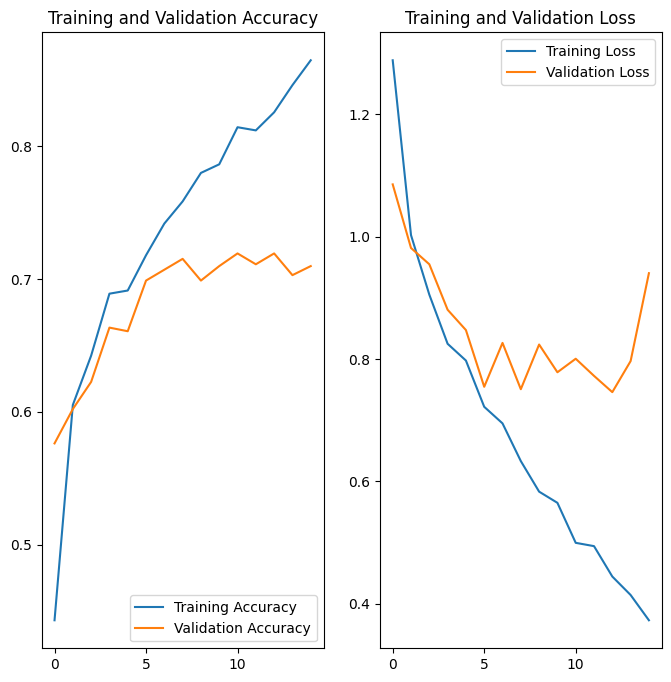

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 새로운 데이터로 예측하기

모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류합니다.

참고: 데이터 증강 및 드롭아웃 레이어는 추론 시 비활성화됩니다.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


  8192/117948 [=>............................] - ETA: 0s


117948/117948 [==============================] - 0s 0us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 130ms/step


This image most likely belongs to sunflowers with a 99.97 percent confidence.


## TensorFlow Lite 사용하기

TensorFlow Lite는 개발자가 모바일, 임베디드 및 엣지 기기에서 모델을 실행할 수 있도록 도와주어 온디바이스 머신 러닝을 지원하는 도구 세트입니다.

### Keras 순차형 모델을 TensorFlow Lite 모델로 변환하기

훈련된 모델을 온디바이스 애플리케이션에 사용하려면 먼저 [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert) 모델이라는 더 작고 효율적인 모델 형식으로 [이를 변환](https://www.tensorflow.org/lite/)해야 합니다.

이 예제에서는 `tf.lite.TFLiteConverter.from_keras_model`을 사용하여 훈련된 Keras 순차형 모델로부터 [TensorFlow Lite](https://www.tensorflow.org/lite/) 모델을 생성합니다.

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpr7kxkt2w/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpr7kxkt2w/assets


2022-12-15 01:29:38.315829: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:29:38.315891: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


이전 단계에서 저장한 TensorFlow Lite 모델에는 여러 함수 서명이 포함될 수 있습니다. Keras 모델 변환기 API는 기본 서명을 자동으로 사용합니다. [TensorFlow Lite 서명](https://www.tensorflow.org/lite/guide/signatures)에 대해 자세히 알아보세요.

### TensorFlow Lite 모델 실행하기

`tf.lite.Interpreter` 클래스를 통해 Python에서 TensorFlow Lite의 저장된 모델 서명에 액세스할 수 있습니다.

`Interpreter`로 모델을 로드합니다.

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

변환된 모델의 서명을 인쇄하여 입력(및 출력)의 이름을 얻습니다.


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

이 예에는 `serving_default`라는 기본 서명이 하나 있습니다. 또한 `'inputs'`의 이름은 `'sequential_1_input'`이고 `'outputs'`의 이름은 `'outputs'`입니다. 이 튜토리얼의 앞부분에서 설명한 것처럼 `Model.summary`를 실행할 때 이러한 첫 번째 및 마지막 Keras 레이어 이름을 조회할 수 있습니다.

이제 다음과 같이 서명 이름을 전달하여 `tf.lite.Interpreter.get_signature_runner`로 샘플 이미지에 대한 추론을 수행하여 로드된 TensorFlow 모델을 테스트할 수 있습니다.

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

튜토리얼의 앞부분에서 수행한 것과 마찬가지로 TensorFlow Lite 모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류할 수 있습니다.

이미 해당 이미지를 텐서화하고 `img_array`로 저장했습니다. 이제 로드된 TensorFlow Lite 모델(`predictions_lite`)의 첫 번째 인수(`'inputs'`의 이름)에 이를 전달하고 softmax 활성화를 계산한 다음, 계산된 확률이 가장 높은 클래스에 대한 예측을 인쇄합니다.

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 99.97 percent confidence.


Lite 모델에서 생성된 예측은 원래 모델에서 생성된 예측과 거의 동일해야 합니다.

In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

1.9073486e-06


5가지 클래스 `'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'` 및 `'tulips'` 중에서 모델은 이미지가 해바라기에 속하는 것으로 예측해야 하며, 이는 TensorFlow Lite 변환 이전과 동일한 결과입니다.


## 다음 단계

이 튜토리얼에서는 이미지 분류를 위해 모델을 훈련 및 테스트하고, 온디바이스 애플리케이션(예: 이미지 분류 앱)에 사용하도록 TensorFlow Lite 형식으로 변환하고, Python API를 사용하여 TensorFlow Lite 모델로 추론을 수행하는 방법을 보여주었습니다.

[튜토리얼](https://www.tensorflow.org/lite/tutorials) 및 [가이드](https://www.tensorflow.org/lite/guide)를 통해 TensorFlow Lite에 대해 자세히 알아볼 수 있습니다.